# AM 207 - Deep Ensembles: A Loss Landscape Perspective

### Circles Toy Dataset Experimentation Notebook

#### Project Team: Emre Erdem, Carter Nakamoto, Anita Mahinpei

## Table of Content

1. [Toy Dataset Creation](#toy-data-creation)
2. [Initial Neural Network Training](#initial-nn-training)
3. [Deep Ensemble with Random Initialization](#deep-ensemble)
4. [Dropout Subspace Sampling](#dropout)
5. [Random Subspace Sampling](#random)
6. [HMC](#hmc)
7. [ADVI](#advi)

In [1]:
import tensorflow as tf
#from keras.datasets import cifar10
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import Input
#from keras.layers import Conv2D, MaxPooling2D
#from keras import backend as K

import numpy as np
import pandas as pd
import pymc3 as pm

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.preprocessing import scale
from sklearn.datasets import make_moons, make_circles, make_blobs
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline
import seaborn as sns 

import theano
import theano.tensor as T
from warnings import filterwarnings

In [2]:
import tensorflow as tf
print(tf.__version__)

2.3.1


In [3]:
%config InlineBackend.figure_format = 'retina'
theano.config.gcc.cxxflags = "-Wno-c++11-narrowing"
floatX = theano.config.floatX
filterwarnings('ignore')
sns.set_style('white')

<a id='toy-data-creation'></a>
## 1. Toy Dataset Creation

In [4]:
TOY_DATA_TYPE = "circles"

# Generate a toy dataset for classification
def generate_toy_data():
    if TOY_DATA_TYPE == "moons":
        return make_moons(noise=0.2, random_state=0, n_samples=2000)
    elif TOY_DATA_TYPE == "circles":
        return make_circles(noise=0.1, random_state=0, n_samples=2000, factor=0.5)
    elif TOY_DATA_TYPE == "blobs":
        return make_blobs(cluster_std=0.8, random_state=0, n_samples=2000, centers=np.array([[-1,-1], [1, 1]]))

X, Y = generate_toy_data()
X = X.astype(floatX)
Y = Y.astype(floatX)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.5)

# Define test data points
def generate_test_points(): 
    if TOY_DATA_TYPE == "moons":
        return [(0.5, -0.4), (0.5, 0.8), (0.5, 0.25), (-0.8, 0.5), (1.7, -0.3), (-1.5, -3), 
                (-1.5, 3), (3, -3), (3, 3)]
    elif TOY_DATA_TYPE == "circles":
        return [(0, 0), (0, 2), (0, -2), (2, 0), (-2, 0), (-1, 0), (-0.75, 0), (-0.5, 0),
               (1, 0), (0.75, 0), (0.5, 0), (0, 1), (0, 0.75), (0, 0.5), (0, -1), (0, -0.75), 
                (0, -0.5)]
    elif TOY_DATA_TYPE == "blobs":
        return [(-5, -5), (-5, 3.5), (5, 5), (5, -3.5), (-1, 1), (-1, -1.5), (1, 1.5)]

test_points = generate_test_points()

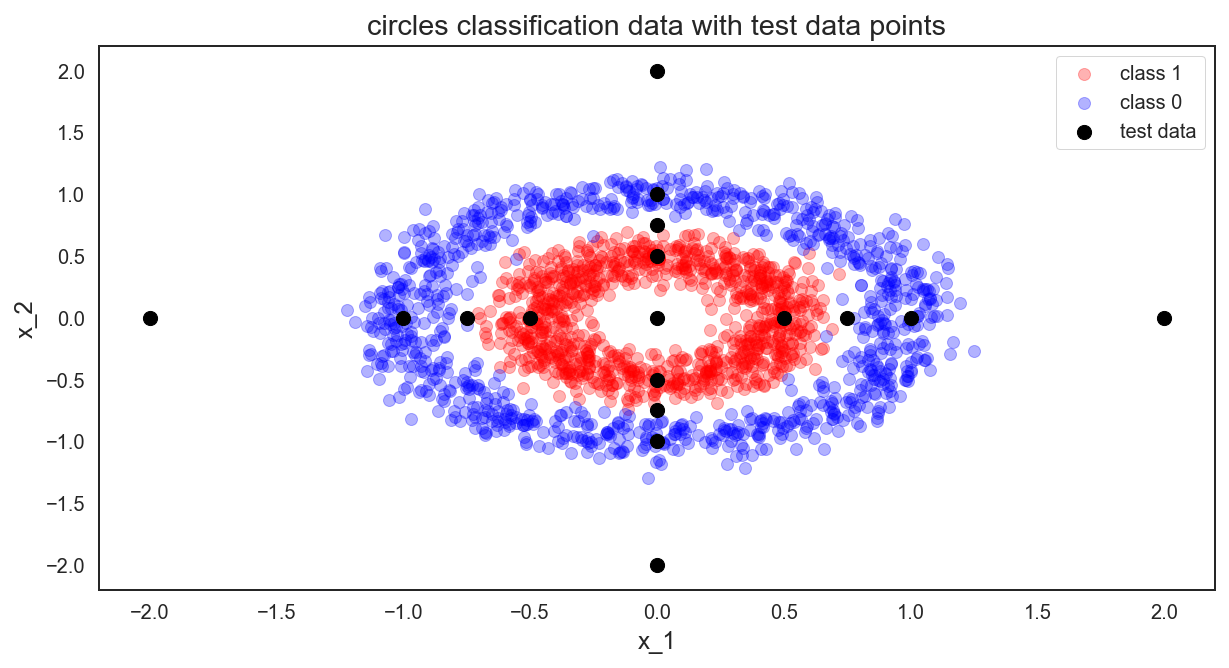

In [5]:
# Visualize our test data points
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.scatter(X[Y == 1, 0], X[Y == 1, 1], alpha=0.3, color='red', label='class 1')
ax.scatter(X[Y == 0, 0], X[Y == 0, 1], alpha=0.3, color='blue', label='class 0')
for i in range(len(test_points)):
    pt = test_points[i]
    if i == 0:
        ax.scatter(pt[0], pt[1], alpha=1., s=50, color='black', label='test data')
    else:
        ax.scatter(pt[0], pt[1], alpha=1., s=50, color='black')
ax.set_xlabel('x_1')
ax.set_ylabel('x_2')
ax.set_title('{} classification data with test data points'.format(TOY_DATA_TYPE))
ax.legend(loc='best')
plt.savefig("{}_data_plot.png".format(TOY_DATA_TYPE))

<a id='initial-nn-training'></a>
## 2. Initial Neural Network Training

In [6]:
batch_size = 256
num_classes = 2
epochs = 1000

In [7]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5, random_state=42)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
print('x_train shape:', X_train.shape)
print('x_test shape:', X_test.shape)

x_train shape: (1000, 2)
x_test shape: (1000, 2)


In [8]:
Y_train.shape

(1000,)

In [9]:
input_shape = X_train.shape[1]
input_shape

2

In [10]:
def get_dropout(input_tensor, p=0.5, mc=False):
    if mc:
        return Dropout(p)(input_tensor)
    else:
        return input_tensor

def get_model(mc=False, p=0.5, act="tanh"):
    if TOY_DATA_TYPE == "blobs" or TOY_DATA_TYPE == "moons" or TOY_DATA_TYPE == "circles":
        inp = Input(shape=(input_shape,))
        x = Dense(64, activation=act)(inp)
        x = get_dropout(x, p=p, mc=mc)
        x = Dense(8, activation=act)(x)
        x = get_dropout(x, p=p, mc=mc)
        out = Dense(1, activation='sigmoid')(x)

        model = Model(inputs=inp, outputs=out)

        model.compile(loss=tf.keras.losses.binary_crossentropy,
                      optimizer=tf.keras.optimizers.Adam(),
                      metrics=['accuracy'])
        return model

In [11]:
base_model = get_model(mc=False)


In [12]:
base_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense (Dense)                (None, 64)                192       
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 520       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 721
Trainable params: 721
Non-trainable params: 0
_________________________________________________________________


In [13]:
es = EarlyStopping(monitor='val_loss', mode='min', patience=20)
history = base_model.fit(X_train, Y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    callbacks=[es],
                    validation_data=(X_test, Y_test))

Epoch 1/1000
4/4 [==============================] - 0s 28ms/step - loss: 0.6962 - accuracy: 0.4870 - val_loss: 0.6955 - val_accuracy: 0.4820
Epoch 2/1000
4/4 [==============================] - 0s 4ms/step - loss: 0.6936 - accuracy: 0.5040 - val_loss: 0.6938 - val_accuracy: 0.4920
Epoch 3/1000
4/4 [==============================] - 0s 4ms/step - loss: 0.6930 - accuracy: 0.5100 - val_loss: 0.6932 - val_accuracy: 0.5400
Epoch 4/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.6925 - accuracy: 0.5660 - val_loss: 0.6931 - val_accuracy: 0.5760
Epoch 5/1000
4/4 [==============================] - 0s 4ms/step - loss: 0.6924 - accuracy: 0.6030 - val_loss: 0.6932 - val_accuracy: 0.5660
Epoch 6/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.6924 - accuracy: 0.5950 - val_loss: 0.6932 - val_accuracy: 0.5870
Epoch 7/1000
4/4 [==============================] - 0s 4ms/step - loss: 0.6922 - accuracy: 0.5820 - val_loss: 0.6932 - val_accuracy: 0.5570
Epoch 8/1000
4/4 [=

4/4 [==============================] - 0s 5ms/step - loss: 0.3541 - accuracy: 0.9640 - val_loss: 0.3614 - val_accuracy: 0.9640
Epoch 118/1000
4/4 [==============================] - 0s 4ms/step - loss: 0.3513 - accuracy: 0.9640 - val_loss: 0.3587 - val_accuracy: 0.9650
Epoch 119/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.3483 - accuracy: 0.9640 - val_loss: 0.3558 - val_accuracy: 0.9650
Epoch 120/1000
4/4 [==============================] - 0s 4ms/step - loss: 0.3454 - accuracy: 0.9650 - val_loss: 0.3528 - val_accuracy: 0.9650
Epoch 121/1000
4/4 [==============================] - 0s 4ms/step - loss: 0.3426 - accuracy: 0.9650 - val_loss: 0.3499 - val_accuracy: 0.9680
Epoch 122/1000
4/4 [==============================] - 0s 4ms/step - loss: 0.3398 - accuracy: 0.9650 - val_loss: 0.3470 - val_accuracy: 0.9680
Epoch 123/1000
4/4 [==============================] - 0s 4ms/step - loss: 0.3371 - accuracy: 0.9650 - val_loss: 0.3443 - val_accuracy: 0.9680
Epoch 124/1000
4/4 [=

Epoch 175/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.2335 - accuracy: 0.9940 - val_loss: 0.2397 - val_accuracy: 0.9860
Epoch 176/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.2318 - accuracy: 0.9940 - val_loss: 0.2383 - val_accuracy: 0.9860
Epoch 177/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.2303 - accuracy: 0.9940 - val_loss: 0.2368 - val_accuracy: 0.9850
Epoch 178/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.2289 - accuracy: 0.9940 - val_loss: 0.2351 - val_accuracy: 0.9860
Epoch 179/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.2274 - accuracy: 0.9940 - val_loss: 0.2336 - val_accuracy: 0.9860
Epoch 180/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.2259 - accuracy: 0.9940 - val_loss: 0.2320 - val_accuracy: 0.9850
Epoch 181/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.2244 - accuracy: 0.9950 - val_loss: 0.2306 - val_accuracy: 0.9860
Epoch 

Epoch 233/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.1614 - accuracy: 0.9970 - val_loss: 0.1672 - val_accuracy: 0.9890
Epoch 234/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.1604 - accuracy: 0.9970 - val_loss: 0.1662 - val_accuracy: 0.9890
Epoch 235/1000
4/4 [==============================] - 0s 4ms/step - loss: 0.1593 - accuracy: 0.9970 - val_loss: 0.1651 - val_accuracy: 0.9890
Epoch 236/1000
4/4 [==============================] - 0s 4ms/step - loss: 0.1584 - accuracy: 0.9970 - val_loss: 0.1641 - val_accuracy: 0.9890
Epoch 237/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.1574 - accuracy: 0.9970 - val_loss: 0.1631 - val_accuracy: 0.9890
Epoch 238/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.1564 - accuracy: 0.9970 - val_loss: 0.1622 - val_accuracy: 0.9890
Epoch 239/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.1554 - accuracy: 0.9970 - val_loss: 0.1612 - val_accuracy: 0.9890
Epoch 

Epoch 291/1000
4/4 [==============================] - 0s 4ms/step - loss: 0.1111 - accuracy: 0.9960 - val_loss: 0.1161 - val_accuracy: 0.9930
Epoch 292/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.1103 - accuracy: 0.9960 - val_loss: 0.1154 - val_accuracy: 0.9940
Epoch 293/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.1096 - accuracy: 0.9960 - val_loss: 0.1148 - val_accuracy: 0.9930
Epoch 294/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.1089 - accuracy: 0.9960 - val_loss: 0.1142 - val_accuracy: 0.9910
Epoch 295/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.1082 - accuracy: 0.9960 - val_loss: 0.1133 - val_accuracy: 0.9920
Epoch 296/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.1074 - accuracy: 0.9960 - val_loss: 0.1125 - val_accuracy: 0.9940
Epoch 297/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.1067 - accuracy: 0.9960 - val_loss: 0.1116 - val_accuracy: 0.9940
Epoch 

Epoch 349/1000
4/4 [==============================] - 0s 4ms/step - loss: 0.0769 - accuracy: 0.9960 - val_loss: 0.0807 - val_accuracy: 0.9950
Epoch 350/1000
4/4 [==============================] - 0s 4ms/step - loss: 0.0765 - accuracy: 0.9960 - val_loss: 0.0802 - val_accuracy: 0.9950
Epoch 351/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.0760 - accuracy: 0.9960 - val_loss: 0.0798 - val_accuracy: 0.9950
Epoch 352/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.0756 - accuracy: 0.9960 - val_loss: 0.0795 - val_accuracy: 0.9950
Epoch 353/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.0753 - accuracy: 0.9960 - val_loss: 0.0790 - val_accuracy: 0.9950
Epoch 354/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.0748 - accuracy: 0.9960 - val_loss: 0.0785 - val_accuracy: 0.9950
Epoch 355/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.0744 - accuracy: 0.9960 - val_loss: 0.0781 - val_accuracy: 0.9950
Epoch 

Epoch 407/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.0571 - accuracy: 0.9960 - val_loss: 0.0601 - val_accuracy: 0.9950
Epoch 408/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.0568 - accuracy: 0.9960 - val_loss: 0.0599 - val_accuracy: 0.9950
Epoch 409/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.0566 - accuracy: 0.9960 - val_loss: 0.0594 - val_accuracy: 0.9950
Epoch 410/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.0563 - accuracy: 0.9960 - val_loss: 0.0592 - val_accuracy: 0.9950
Epoch 411/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.0561 - accuracy: 0.9960 - val_loss: 0.0589 - val_accuracy: 0.9950
Epoch 412/1000
4/4 [==============================] - 0s 4ms/step - loss: 0.0558 - accuracy: 0.9960 - val_loss: 0.0587 - val_accuracy: 0.9950
Epoch 413/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.0556 - accuracy: 0.9960 - val_loss: 0.0585 - val_accuracy: 0.9950
Epoch 

Epoch 465/1000
4/4 [==============================] - 0s 6ms/step - loss: 0.0442 - accuracy: 0.9960 - val_loss: 0.0469 - val_accuracy: 0.9950
Epoch 466/1000
4/4 [==============================] - 0s 6ms/step - loss: 0.0440 - accuracy: 0.9960 - val_loss: 0.0469 - val_accuracy: 0.9950
Epoch 467/1000
4/4 [==============================] - 0s 6ms/step - loss: 0.0438 - accuracy: 0.9960 - val_loss: 0.0468 - val_accuracy: 0.9950
Epoch 468/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.0437 - accuracy: 0.9960 - val_loss: 0.0462 - val_accuracy: 0.9950
Epoch 469/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.0435 - accuracy: 0.9960 - val_loss: 0.0461 - val_accuracy: 0.9950
Epoch 470/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.0433 - accuracy: 0.9960 - val_loss: 0.0459 - val_accuracy: 0.9950
Epoch 471/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.0431 - accuracy: 0.9960 - val_loss: 0.0459 - val_accuracy: 0.9950
Epoch 

Epoch 523/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.0347 - accuracy: 0.9970 - val_loss: 0.0382 - val_accuracy: 0.9930
Epoch 524/1000
4/4 [==============================] - 0s 4ms/step - loss: 0.0345 - accuracy: 0.9970 - val_loss: 0.0378 - val_accuracy: 0.9930
Epoch 525/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.0343 - accuracy: 0.9970 - val_loss: 0.0378 - val_accuracy: 0.9930
Epoch 526/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.0343 - accuracy: 0.9970 - val_loss: 0.0379 - val_accuracy: 0.9930
Epoch 527/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.0341 - accuracy: 0.9960 - val_loss: 0.0379 - val_accuracy: 0.9930
Epoch 528/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.0341 - accuracy: 0.9970 - val_loss: 0.0373 - val_accuracy: 0.9930
Epoch 529/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.0338 - accuracy: 0.9970 - val_loss: 0.0376 - val_accuracy: 0.9930
Epoch 

Epoch 581/1000
4/4 [==============================] - 0s 10ms/step - loss: 0.0275 - accuracy: 0.9960 - val_loss: 0.0328 - val_accuracy: 0.9930
Epoch 582/1000
4/4 [==============================] - 0s 8ms/step - loss: 0.0273 - accuracy: 0.9960 - val_loss: 0.0331 - val_accuracy: 0.9930
Epoch 583/1000
4/4 [==============================] - 0s 6ms/step - loss: 0.0271 - accuracy: 0.9960 - val_loss: 0.0330 - val_accuracy: 0.9930
Epoch 584/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.0271 - accuracy: 0.9960 - val_loss: 0.0327 - val_accuracy: 0.9930
Epoch 585/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.0270 - accuracy: 0.9970 - val_loss: 0.0323 - val_accuracy: 0.9930
Epoch 586/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.0268 - accuracy: 0.9960 - val_loss: 0.0325 - val_accuracy: 0.9930
Epoch 587/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.0267 - accuracy: 0.9960 - val_loss: 0.0325 - val_accuracy: 0.9930
Epoch

Epoch 639/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.0223 - accuracy: 0.9960 - val_loss: 0.0297 - val_accuracy: 0.9930
Epoch 640/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.0223 - accuracy: 0.9970 - val_loss: 0.0293 - val_accuracy: 0.9930
Epoch 641/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.0222 - accuracy: 0.9960 - val_loss: 0.0292 - val_accuracy: 0.9930
Epoch 642/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.0221 - accuracy: 0.9960 - val_loss: 0.0296 - val_accuracy: 0.9930
Epoch 643/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.0221 - accuracy: 0.9960 - val_loss: 0.0300 - val_accuracy: 0.9930
Epoch 644/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.0220 - accuracy: 0.9960 - val_loss: 0.0302 - val_accuracy: 0.9930
Epoch 645/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.0220 - accuracy: 0.9960 - val_loss: 0.0297 - val_accuracy: 0.9930
Epoch 

Epoch 697/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.0191 - accuracy: 0.9960 - val_loss: 0.0282 - val_accuracy: 0.9930
Epoch 698/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.0190 - accuracy: 0.9960 - val_loss: 0.0282 - val_accuracy: 0.9930
Epoch 699/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.0190 - accuracy: 0.9970 - val_loss: 0.0282 - val_accuracy: 0.9920
Epoch 700/1000
4/4 [==============================] - 0s 4ms/step - loss: 0.0190 - accuracy: 0.9970 - val_loss: 0.0279 - val_accuracy: 0.9920
Epoch 701/1000
4/4 [==============================] - 0s 4ms/step - loss: 0.0190 - accuracy: 0.9960 - val_loss: 0.0282 - val_accuracy: 0.9930
Epoch 702/1000
4/4 [==============================] - 0s 4ms/step - loss: 0.0188 - accuracy: 0.9960 - val_loss: 0.0280 - val_accuracy: 0.9930
Epoch 703/1000
4/4 [==============================] - 0s 4ms/step - loss: 0.0189 - accuracy: 0.9970 - val_loss: 0.0275 - val_accuracy: 0.9930
Epoch 

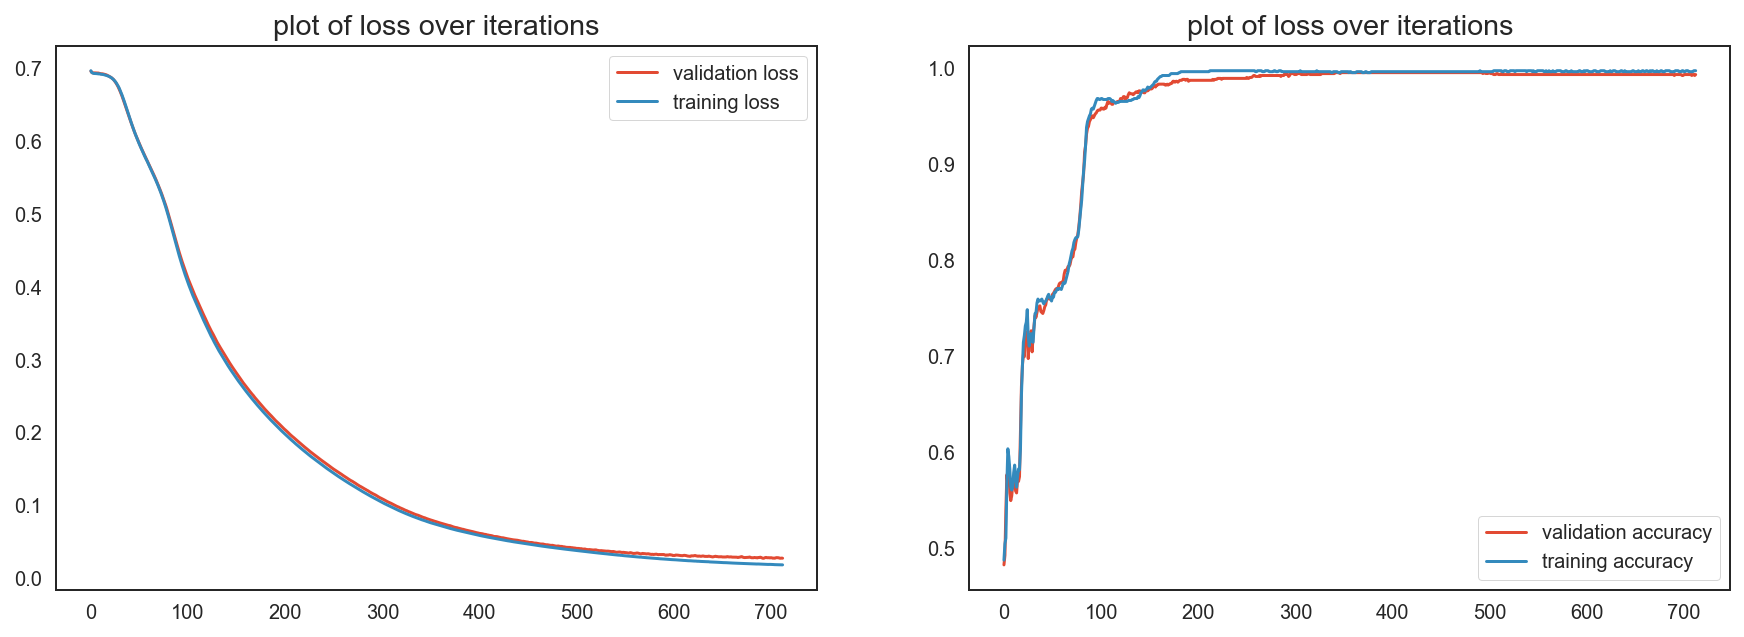

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].plot(history.history["val_loss"], label="validation loss")
ax[0].plot(history.history["loss"], label="training loss")
ax[0].set_title("plot of loss over iterations")
ax[0].legend()
ax[1].plot(history.history["val_accuracy"], label="validation accuracy")
ax[1].plot(history.history["accuracy"], label="training accuracy")
ax[1].set_title("plot of loss over iterations")
ax[1].legend()
plt.show()

In [15]:
weights = base_model.get_weights()
base_model.save_weights('initial_model_weights.h5')

In [16]:
grid = pm.floatX(np.mgrid[-3:3:100j,-3:3:100j])
grid_2d = grid.reshape(2, -1).T
dummy_out = np.ones(grid.shape[1], dtype=np.int8)

In [17]:
pred2 = base_model.predict(grid_2d)[:,0].flatten()
pred = base_model.predict(X_test)[:,0].flatten() > 0.5

Text(0, 0.5, 'posterior predictive mean probability of class label = 0')

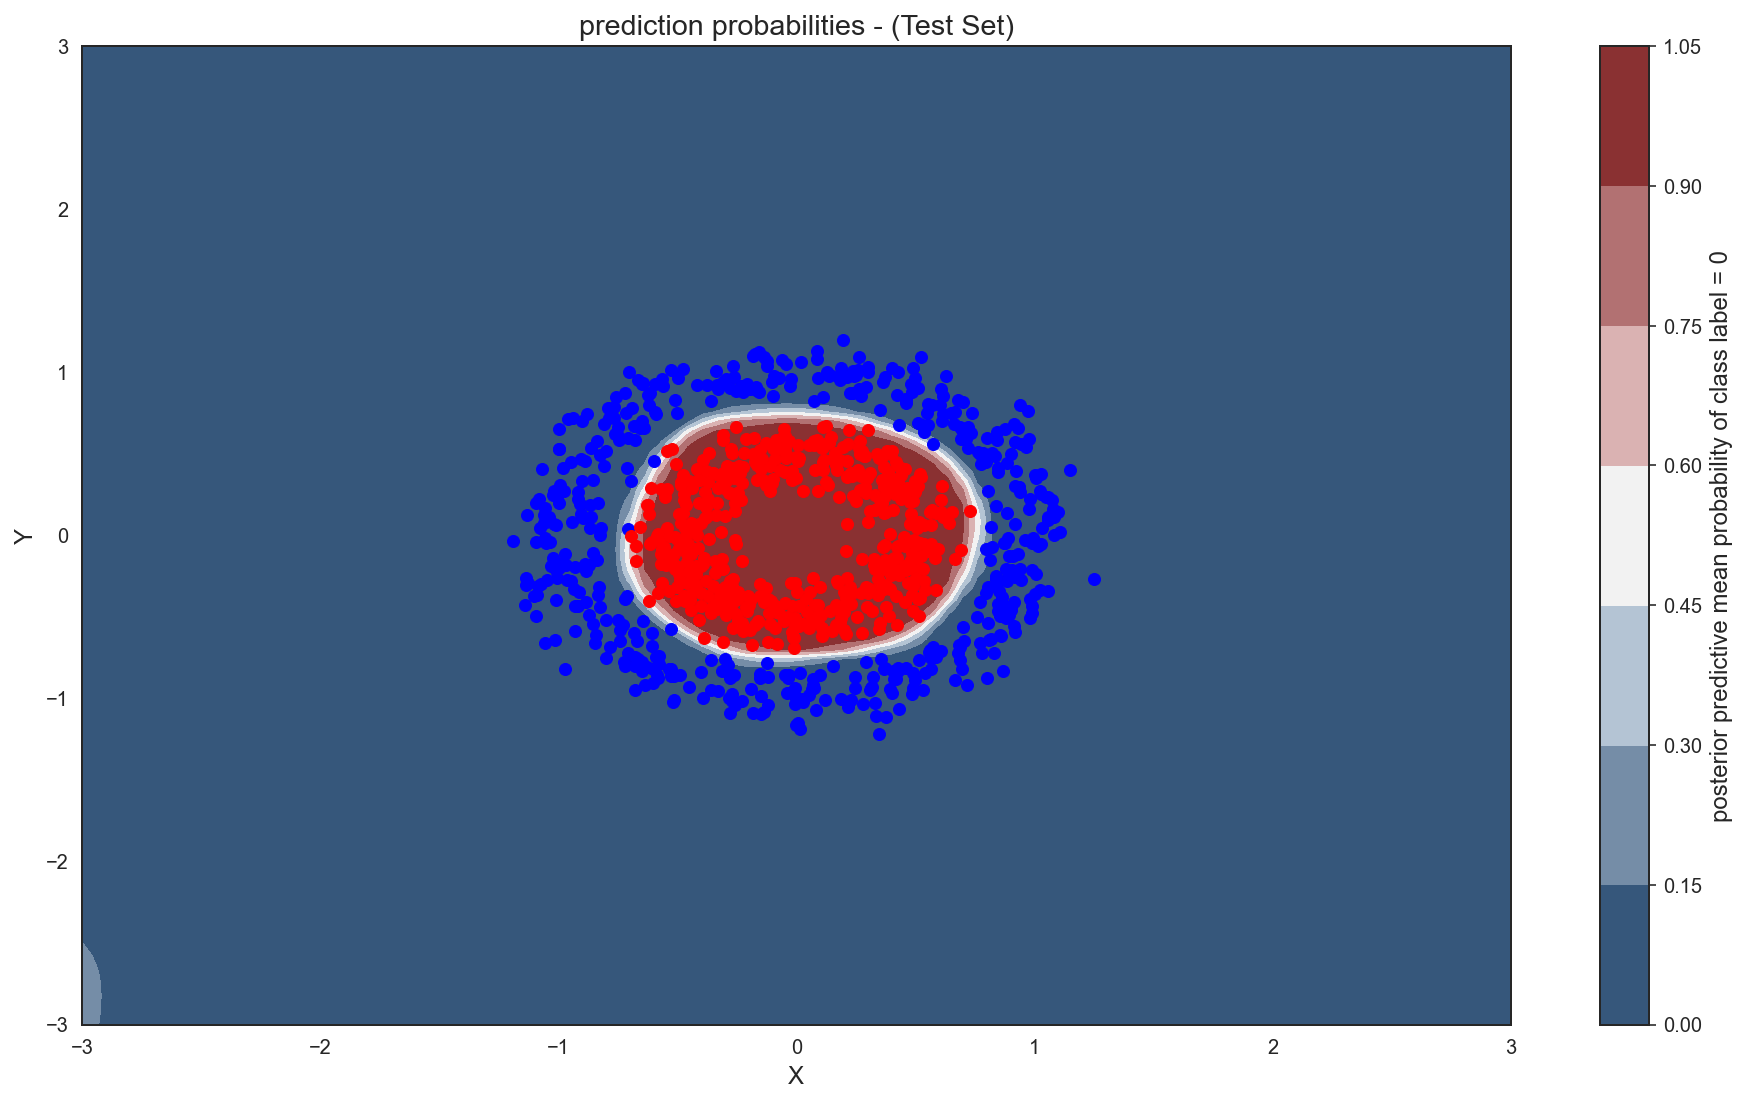

In [18]:
cmap = sns.diverging_palette(250, 12, s=85, l=25, as_cmap=True)
fig, ax = plt.subplots(figsize=(16, 9))
contour = ax.contourf(grid[0], grid[1], pred2.reshape(100, 100), cmap=cmap)
ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1], color='b')
ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y')
plt.title("prediction probabilities - (Test Set)")
cbar.ax.set_ylabel('posterior predictive mean probability of class label = 0')

<a id='deep-ensemble'></a>
## 3. Deep Ensemble with Random Initialization

In [19]:
ensembles = 30
ens_test_probs = []
ens_ood_probs = []
ens_weights = []
grid_preds = []

for i in range(ensembles):
    
    # Fit neural network model
    model = get_model(mc=False)
    nn = model.fit(X_train, Y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=0,
                        callbacks=[es],
                    validation_data=(X_test, Y_test))
    
    #Get Dense model weights
    weights = model.get_weights()
    flat_weight_array = np.array([])
    for weight in weights:
        flat_weight_array = np.concatenate((flat_weight_array, weight.flatten()))
    ens_weights.append(flat_weight_array)
    
    # Accuracy of model
    score = model.evaluate(X_test, Y_test, verbose=0)
    #print('Test loss:', np.round(score[0],2))
    test_prob = model.predict(X_test)
    
    ens_test_probs.append(test_prob)
    print("Iteration: " + str(i+1) +' Test accuracy:'+ str(np.round(score[1],4)))
        
    #Predictions & uncertainty for test points
    ood_prob = model.predict(np.array(test_points))
    ens_ood_probs.append(ood_prob)

    pred2 = model.predict(grid_2d)[:,0].flatten()
    grid_preds.append(pred2)

Iteration: 1 Test accuracy:0.991
Iteration: 2 Test accuracy:0.992
Iteration: 3 Test accuracy:0.991
Iteration: 4 Test accuracy:0.992
Iteration: 5 Test accuracy:0.992
Iteration: 6 Test accuracy:0.986
Iteration: 7 Test accuracy:0.991
Iteration: 8 Test accuracy:0.991
Iteration: 9 Test accuracy:0.992
Iteration: 10 Test accuracy:0.992
Iteration: 11 Test accuracy:0.991
Iteration: 12 Test accuracy:0.986
Iteration: 13 Test accuracy:0.992
Iteration: 14 Test accuracy:0.992
Iteration: 15 Test accuracy:0.991
Iteration: 16 Test accuracy:0.992
Iteration: 17 Test accuracy:0.992
Iteration: 18 Test accuracy:0.99
Iteration: 19 Test accuracy:0.991
Iteration: 20 Test accuracy:0.991
Iteration: 21 Test accuracy:0.99
Iteration: 22 Test accuracy:0.99
Iteration: 23 Test accuracy:0.991
Iteration: 24 Test accuracy:0.992
Iteration: 25 Test accuracy:0.991
Iteration: 26 Test accuracy:0.992
Iteration: 27 Test accuracy:0.991
Iteration: 28 Test accuracy:0.991
Iteration: 29 Test accuracy:0.992
Iteration: 30 Test accurac

In [20]:
ens_mean = np.mean(np.array(ens_test_probs),axis=0)
pred_test_labels = (ens_mean > 0.5).astype(np.int) 
score = accuracy_score(Y_test, pred_test_labels)
print("Ensemble prediction accuracy score for test data: ", score)

Ensemble prediction accuracy score for test data:  0.992


In [21]:
ens_variance = np.std(np.array(ens_ood_probs),axis=0)**2

for i in range(len(test_points)):
    print("uncertainty for test point: {} : {}".format(test_points[i], ens_variance[i][0]))

uncertainty for test point: (0, 0) : 3.2920477224251954e-06
uncertainty for test point: (0, 2) : 1.369657002214808e-05
uncertainty for test point: (0, -2) : 1.1893353985215072e-05
uncertainty for test point: (2, 0) : 1.3476082131091971e-05
uncertainty for test point: (-2, 0) : 1.4826417100266553e-05
uncertainty for test point: (-1, 0) : 2.9567052479251288e-05
uncertainty for test point: (-0.75, 0) : 0.018611017614603043
uncertainty for test point: (-0.5, 0) : 3.2343834845960373e-06
uncertainty for test point: (1, 0) : 3.209299029549584e-05
uncertainty for test point: (0.75, 0) : 0.009294087998569012
uncertainty for test point: (0.5, 0) : 3.15675401907356e-06
uncertainty for test point: (0, 1) : 2.4896784452721477e-05
uncertainty for test point: (0, 0.75) : 0.01164599321782589
uncertainty for test point: (0, 0.5) : 3.0143041840346996e-06
uncertainty for test point: (0, -1) : 2.460368341417052e-05
uncertainty for test point: (0, -0.75) : 0.00987060833722353
uncertainty for test point: (0

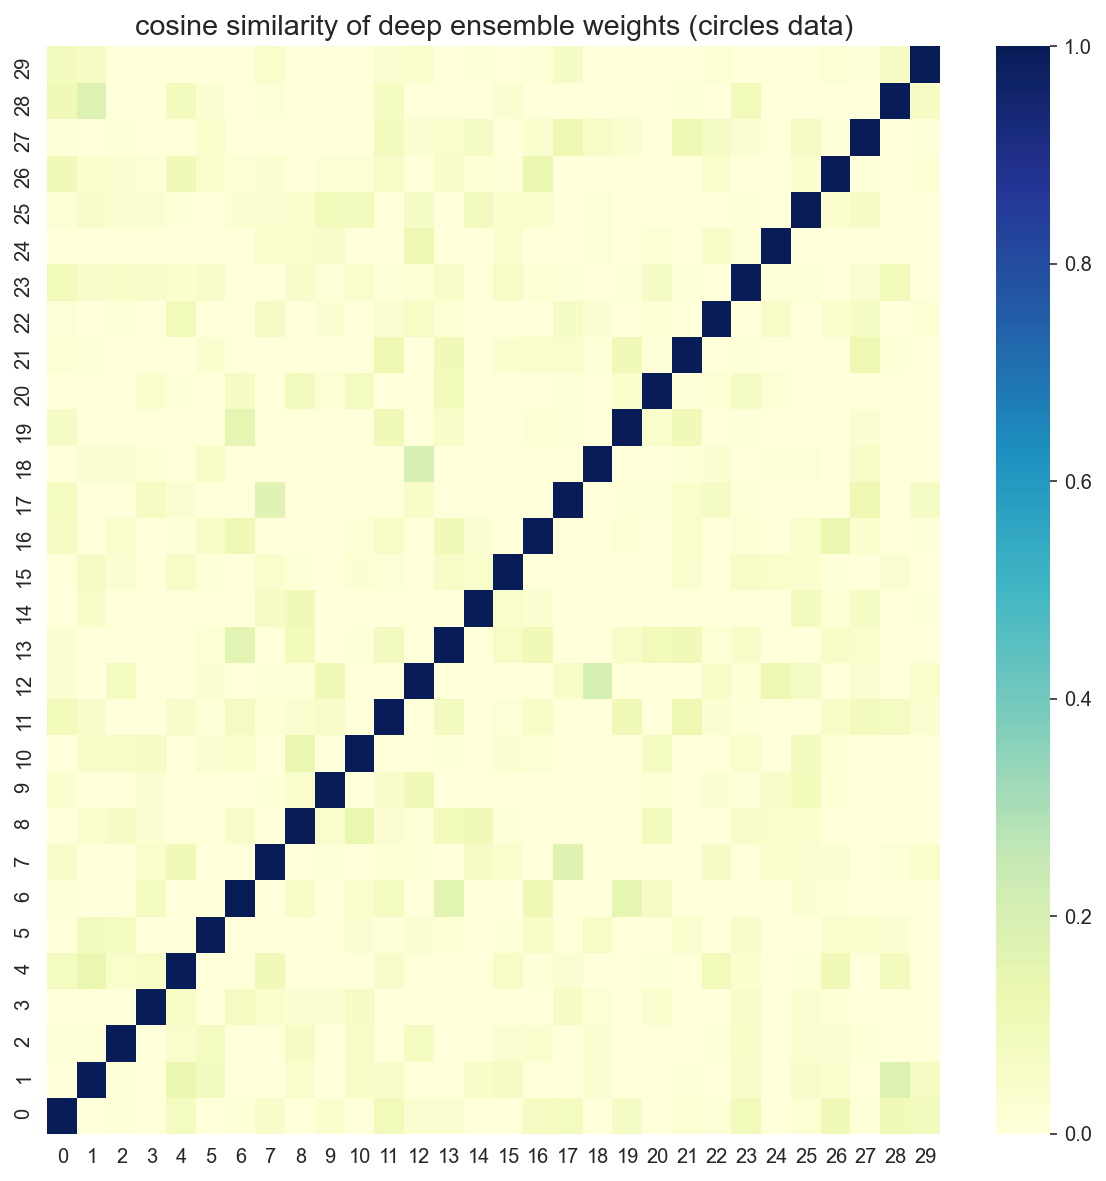

In [22]:
df = pd.DataFrame(np.array(ens_weights))

fig = plt.figure(figsize=(10,10))
ax = sns.heatmap(cosine_similarity(df),vmin=0, vmax=1, cmap="YlGnBu") # vmin=0.9, vmax=1
plt.title("cosine similarity of deep ensemble weights ({} data)".format(TOY_DATA_TYPE))
ax.invert_yaxis()
plt.savefig("{}_cos_similarity_plot_ensemble.png".format(TOY_DATA_TYPE))

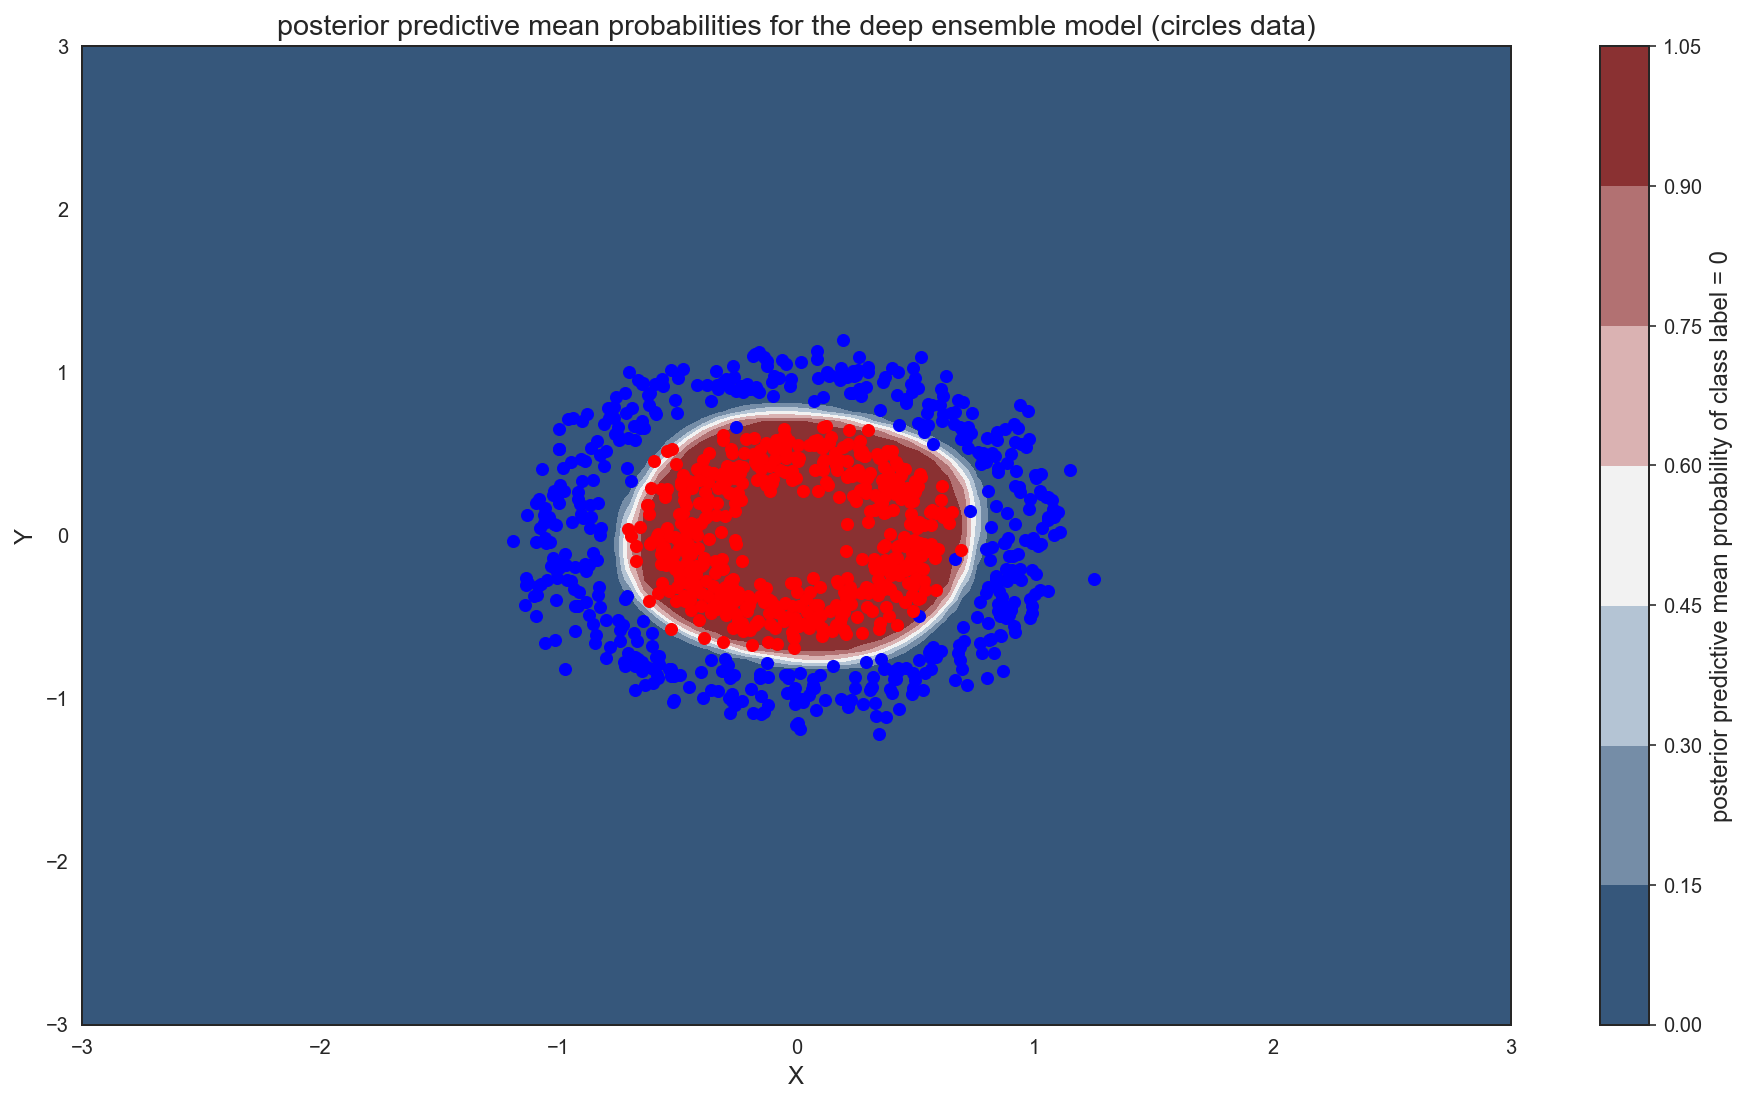

In [23]:
cmap = sns.diverging_palette(250, 12, s=85, l=25, as_cmap=True)
fig, ax = plt.subplots(figsize=(16, 9))
contour = ax.contourf(grid[0], grid[1], np.mean(np.array(grid_preds),axis=0).reshape(100, 100), cmap=cmap)
ax.scatter(X_test[Y_test==0, 0], X_test[Y_test==0, 1], color='b')
ax.scatter(X_test[Y_test==1, 0], X_test[Y_test==1, 1], color='r')
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y');
plt.title("posterior predictive mean probabilities for the deep ensemble model ({} data)".format(TOY_DATA_TYPE))
cbar.ax.set_ylabel('posterior predictive mean probability of class label = 0')
plt.savefig("{}_posterior_predictive_plot_ensemble.png".format(TOY_DATA_TYPE))

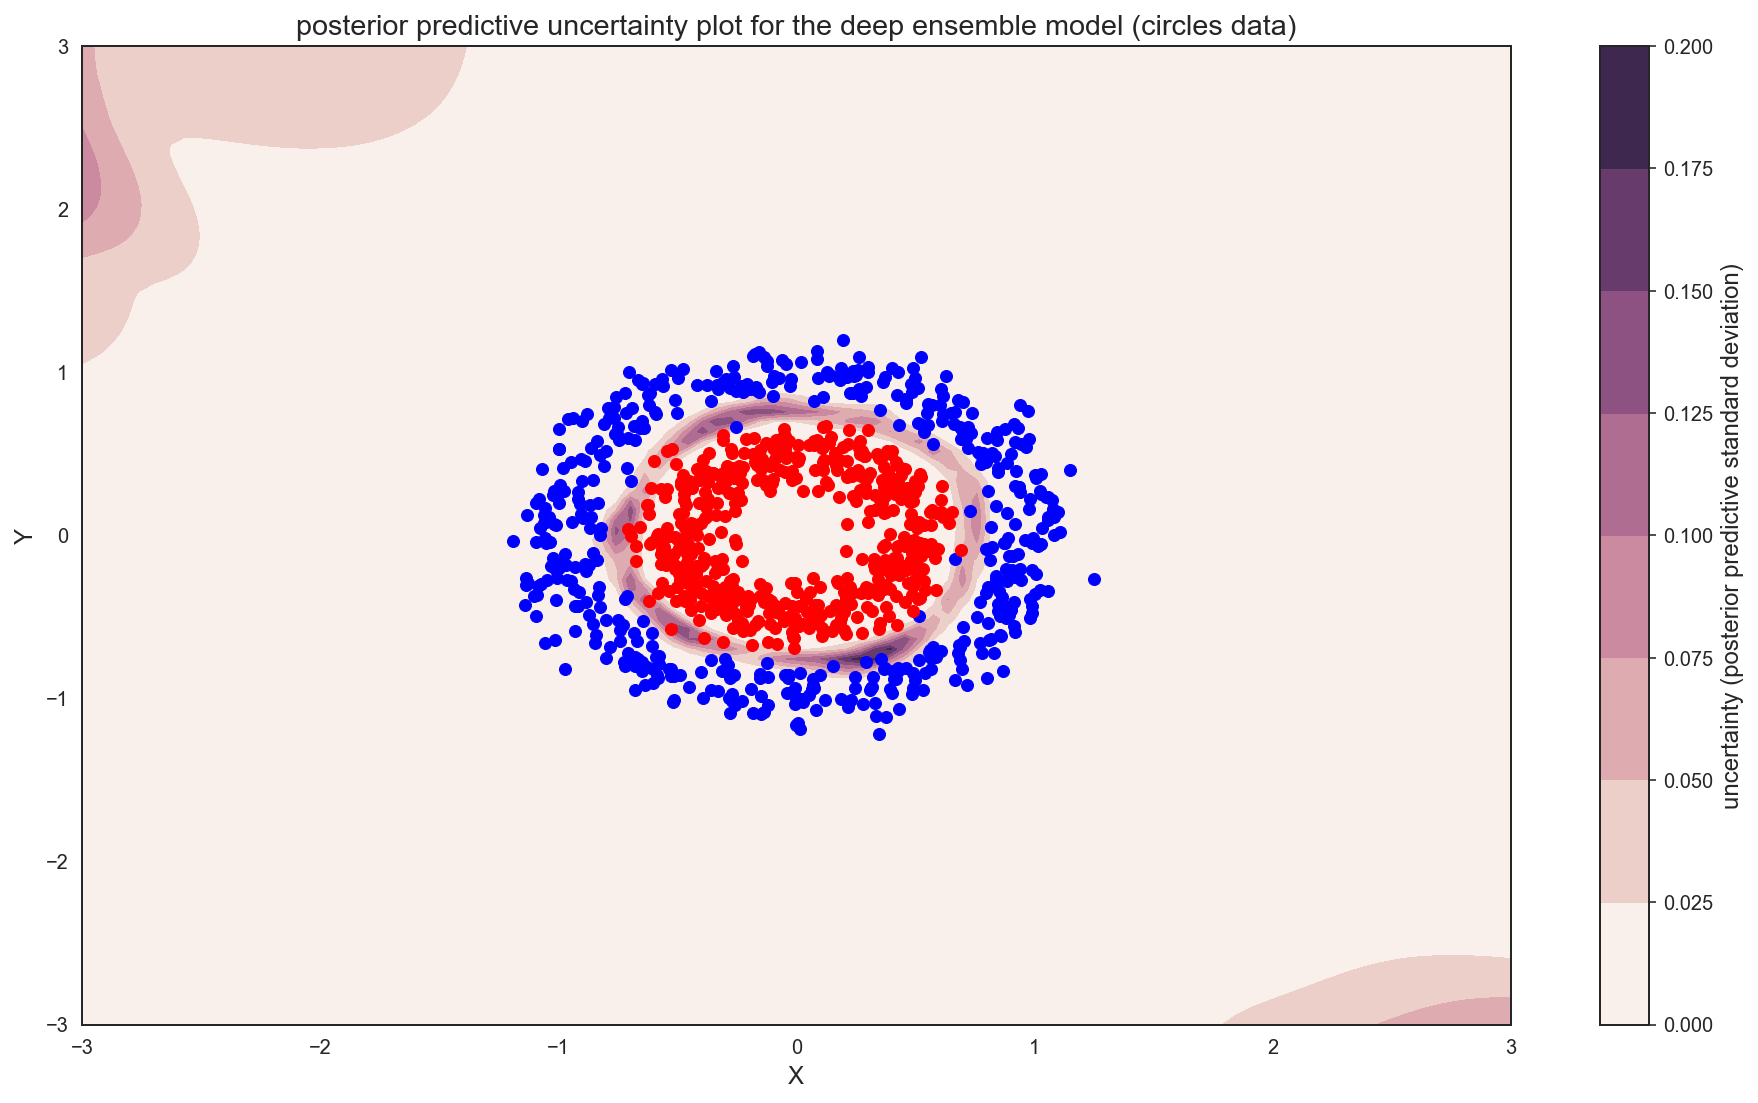

In [24]:
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig, ax = plt.subplots(figsize=(16, 9))
contour = ax.contourf(grid[0], grid[1], np.std(np.array(grid_preds),axis=0).reshape(100, 100), cmap=cmap)
ax.scatter(X_test[Y_test==0, 0], X_test[Y_test==0, 1], color='b')
ax.scatter(X_test[Y_test==1, 0], X_test[Y_test==1, 1], color='r')
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y');
plt.title("posterior predictive uncertainty plot for the deep ensemble model ({} data)".format(TOY_DATA_TYPE))
cbar.ax.set_ylabel('uncertainty (posterior predictive standard deviation)')
plt.savefig("{}_uncertainty_plot_ensemble.png".format(TOY_DATA_TYPE))

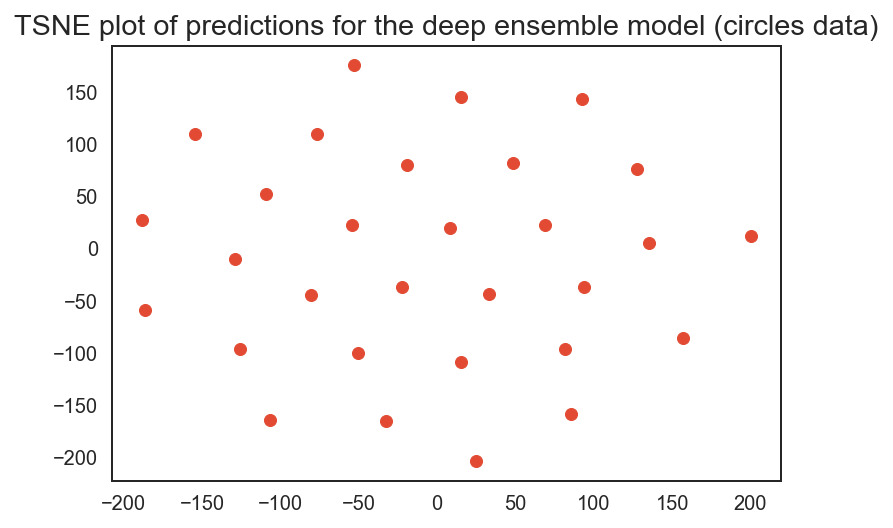

In [25]:
tsne = TSNE(n_components=2)
ens_test_probs_pca = tsne.fit_transform(np.array(ens_test_probs).reshape(30, 1000))


plt.scatter(ens_test_probs_pca[:,0], ens_test_probs_pca[:,1])
plt.title("TSNE plot of predictions for the deep ensemble model ({} data)".format(TOY_DATA_TYPE))
plt.savefig("{}_tsne_plot_ensemble.png".format(TOY_DATA_TYPE))

<a id='dropout'></a>
## 4. Dropout Subspace Sampling

In [26]:
bayes_iters = 30
dropout_post_predictions = []
dropout_ood_probs = []
drop_weights = []
grid_preds = []

for i in range(bayes_iters):
    #Generate random p value for Dropout ratio
    p_rand = np.random.random()
    
    drop_model = get_model(mc=True, p=p_rand)
    
    #Initialize model with pre-trained weights
    drop_model.load_weights('initial_model_weights.h5')
    h_mc = drop_model.fit(X_train, Y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=0,
                        callbacks=[es],
                        validation_data=(X_test, Y_test))
    
    #Get Dense model weights
    weights = drop_model.get_weights()
    flat_weight_array = np.array([])
    for weight in weights:
        flat_weight_array = np.concatenate((flat_weight_array, weight.flatten()))
    drop_weights.append(flat_weight_array)
    
    # Accuracy of model
    score = drop_model.evaluate(X_test, Y_test, verbose=0)
    #print('Test loss:', np.round(score[0],2))
    print("Iteration: " + str(i+1) + " Random p: " + str(np.round(p_rand,2)) + ' Test accuracy: ', str(np.round(score[1],4)))
    
    #Posterior predictions
    y_pred = drop_model.predict(X_test)
    dropout_post_predictions.append(y_pred)
    
    #Predictions & uncertainty for test points
    ood_prob = drop_model.predict(np.array(test_points))
    dropout_ood_probs.append(ood_prob)
    
    pred2 = drop_model.predict(grid_2d)[:,0].flatten()
    grid_preds.append(pred2)

Iteration: 1 Random p: 0.02 Test accuracy:  0.993
Iteration: 2 Random p: 0.26 Test accuracy:  0.993
Iteration: 3 Random p: 0.62 Test accuracy:  0.996
Iteration: 4 Random p: 0.67 Test accuracy:  0.994
Iteration: 5 Random p: 0.19 Test accuracy:  0.993
Iteration: 6 Random p: 0.95 Test accuracy:  0.993
Iteration: 7 Random p: 0.73 Test accuracy:  0.988
Iteration: 8 Random p: 0.78 Test accuracy:  0.99
Iteration: 9 Random p: 0.5 Test accuracy:  0.994
Iteration: 10 Random p: 0.98 Test accuracy:  0.994
Iteration: 11 Random p: 1.0 Test accuracy:  0.994
Iteration: 12 Random p: 0.9 Test accuracy:  0.992
Iteration: 13 Random p: 0.51 Test accuracy:  0.995
Iteration: 14 Random p: 0.51 Test accuracy:  0.994
Iteration: 15 Random p: 0.22 Test accuracy:  0.993
Iteration: 16 Random p: 0.05 Test accuracy:  0.993
Iteration: 17 Random p: 0.35 Test accuracy:  0.994
Iteration: 18 Random p: 0.44 Test accuracy:  0.993
Iteration: 19 Random p: 0.5 Test accuracy:  0.994
Iteration: 20 Random p: 0.22 Test accuracy:  

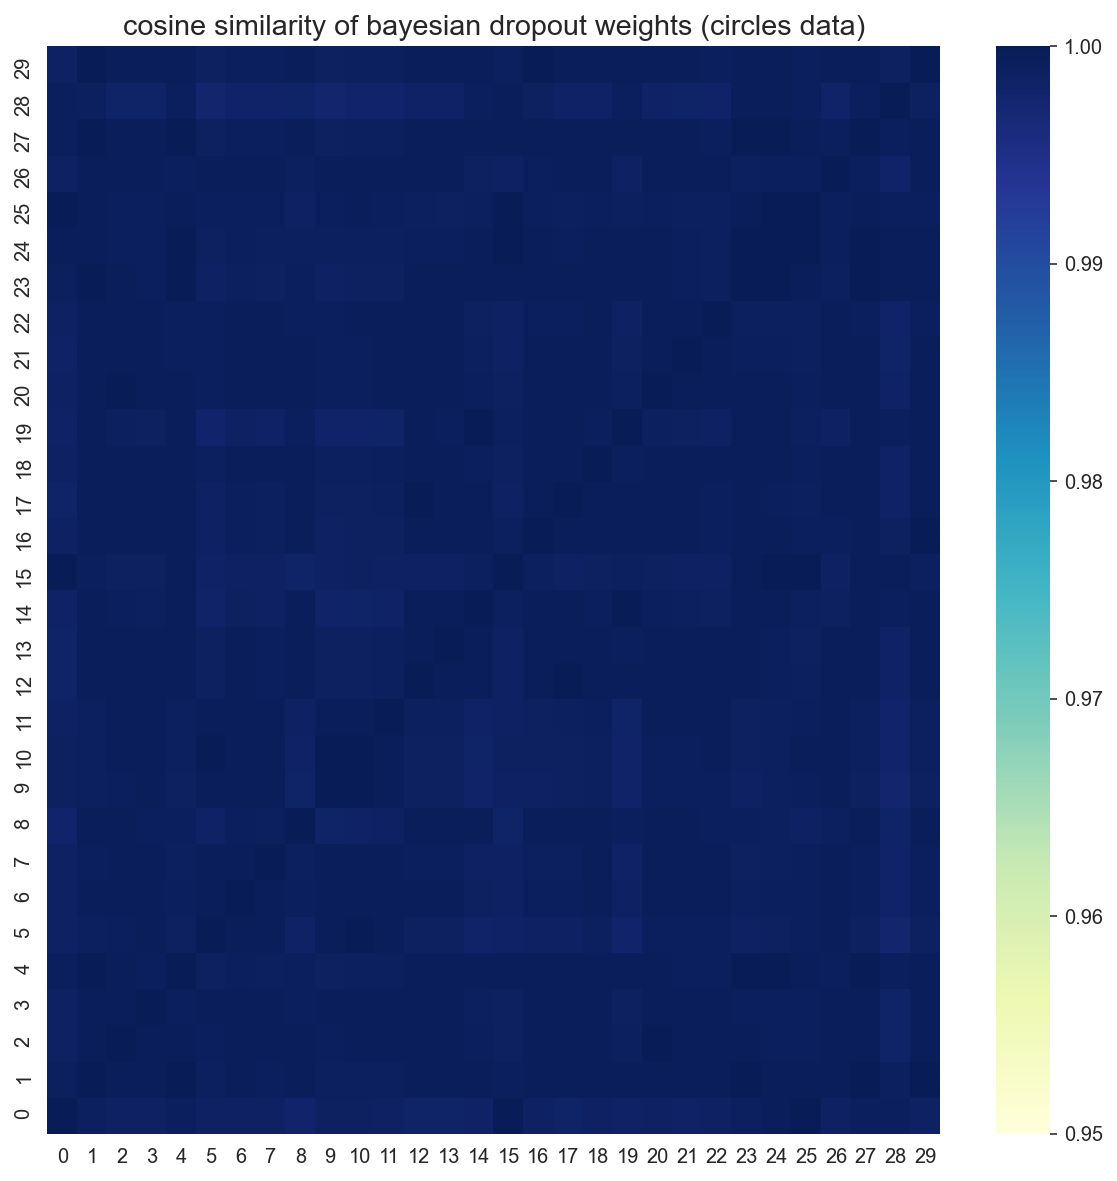

In [27]:
df = pd.DataFrame(np.array(drop_weights))

fig = plt.figure(figsize=(10,10))
ax = sns.heatmap(cosine_similarity(df),vmin=0.95, vmax=1, cmap="YlGnBu") # vmin=0.9, vmax=1
plt.title("cosine similarity of bayesian dropout weights ({} data)".format(TOY_DATA_TYPE))
ax.invert_yaxis()
plt.savefig("{}_cos_similarity_plot_dropout.png".format(TOY_DATA_TYPE))

In [28]:
dropout_posterior_mean_preds = np.mean(np.array(dropout_post_predictions),axis=0)
dropout_posterior_mean_preds.shape

(1000, 1)

In [29]:
dropout_pred_test_labels = (dropout_posterior_mean_preds > 0.5).astype(np.int) 
dropout_acc_score = accuracy_score(Y_test, dropout_pred_test_labels)
print("Bayesian Dropout posterior predictive mean accuracy score for test data: ", dropout_acc_score)

Bayesian Dropout posterior predictive mean accuracy score for test data:  0.994


In [30]:
drop_ood_variance = np.std(np.array(dropout_ood_probs),axis=0)**2

for i in range(len(test_points)):
    print("uncertainty for test point: {} : {}".format(test_points[i], drop_ood_variance[i][0]))

uncertainty for test point: (0, 0) : 6.074296834412962e-07
uncertainty for test point: (0, 2) : 2.453935223911685e-07
uncertainty for test point: (0, -2) : 9.078298290887687e-08
uncertainty for test point: (2, 0) : 1.1350582553859567e-06
uncertainty for test point: (-2, 0) : 3.2595590671036234e-09
uncertainty for test point: (-1, 0) : 4.061631955210032e-07
uncertainty for test point: (-0.75, 0) : 0.025561904534697533
uncertainty for test point: (-0.5, 0) : 6.854680805190583e-07
uncertainty for test point: (1, 0) : 8.171726949512959e-05
uncertainty for test point: (0.75, 0) : 0.04146644100546837
uncertainty for test point: (0.5, 0) : 6.582817491107562e-07
uncertainty for test point: (0, 1) : 5.955462256679311e-06
uncertainty for test point: (0, 0.75) : 0.056261200457811356
uncertainty for test point: (0, 0.5) : 6.380777790582215e-07
uncertainty for test point: (0, -1) : 4.991231890016934e-07
uncertainty for test point: (0, -0.75) : 0.05352749302983284
uncertainty for test point: (0, -0.

In [31]:
dropout_pred_test_labels.shape

(1000, 1)

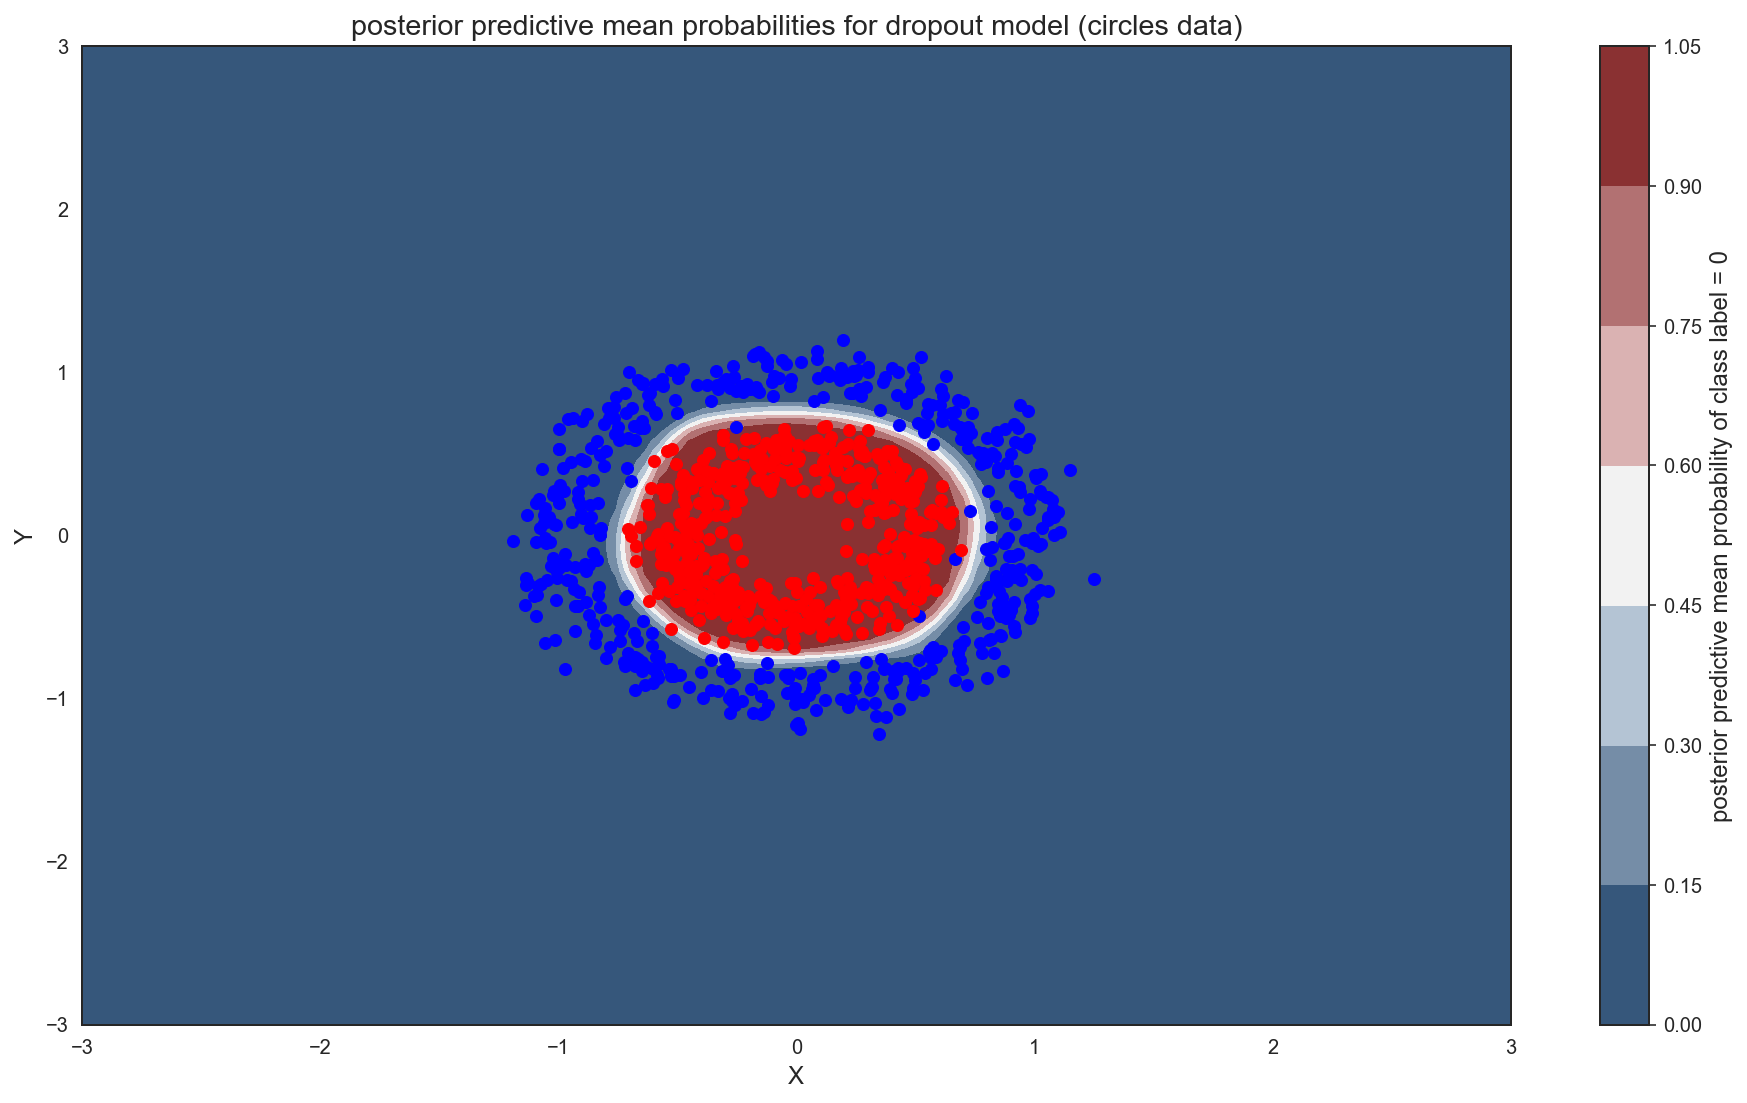

In [32]:
cmap = sns.diverging_palette(250, 12, s=85, l=25, as_cmap=True)
fig, ax = plt.subplots(figsize=(16, 9))
contour = ax.contourf(grid[0], grid[1], np.mean(np.array(grid_preds),axis=0).reshape(100, 100), cmap=cmap)
ax.scatter(X_test[Y_test==0, 0], X_test[Y_test==0, 1], color='b')
ax.scatter(X_test[Y_test==1, 0], X_test[Y_test==1, 1], color='r')
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y');
plt.title("posterior predictive mean probabilities for dropout model ({} data)".format(TOY_DATA_TYPE))
cbar.ax.set_ylabel('posterior predictive mean probability of class label = 0')
plt.savefig("{}_posterior_predictive_plot_dropout.png".format(TOY_DATA_TYPE))

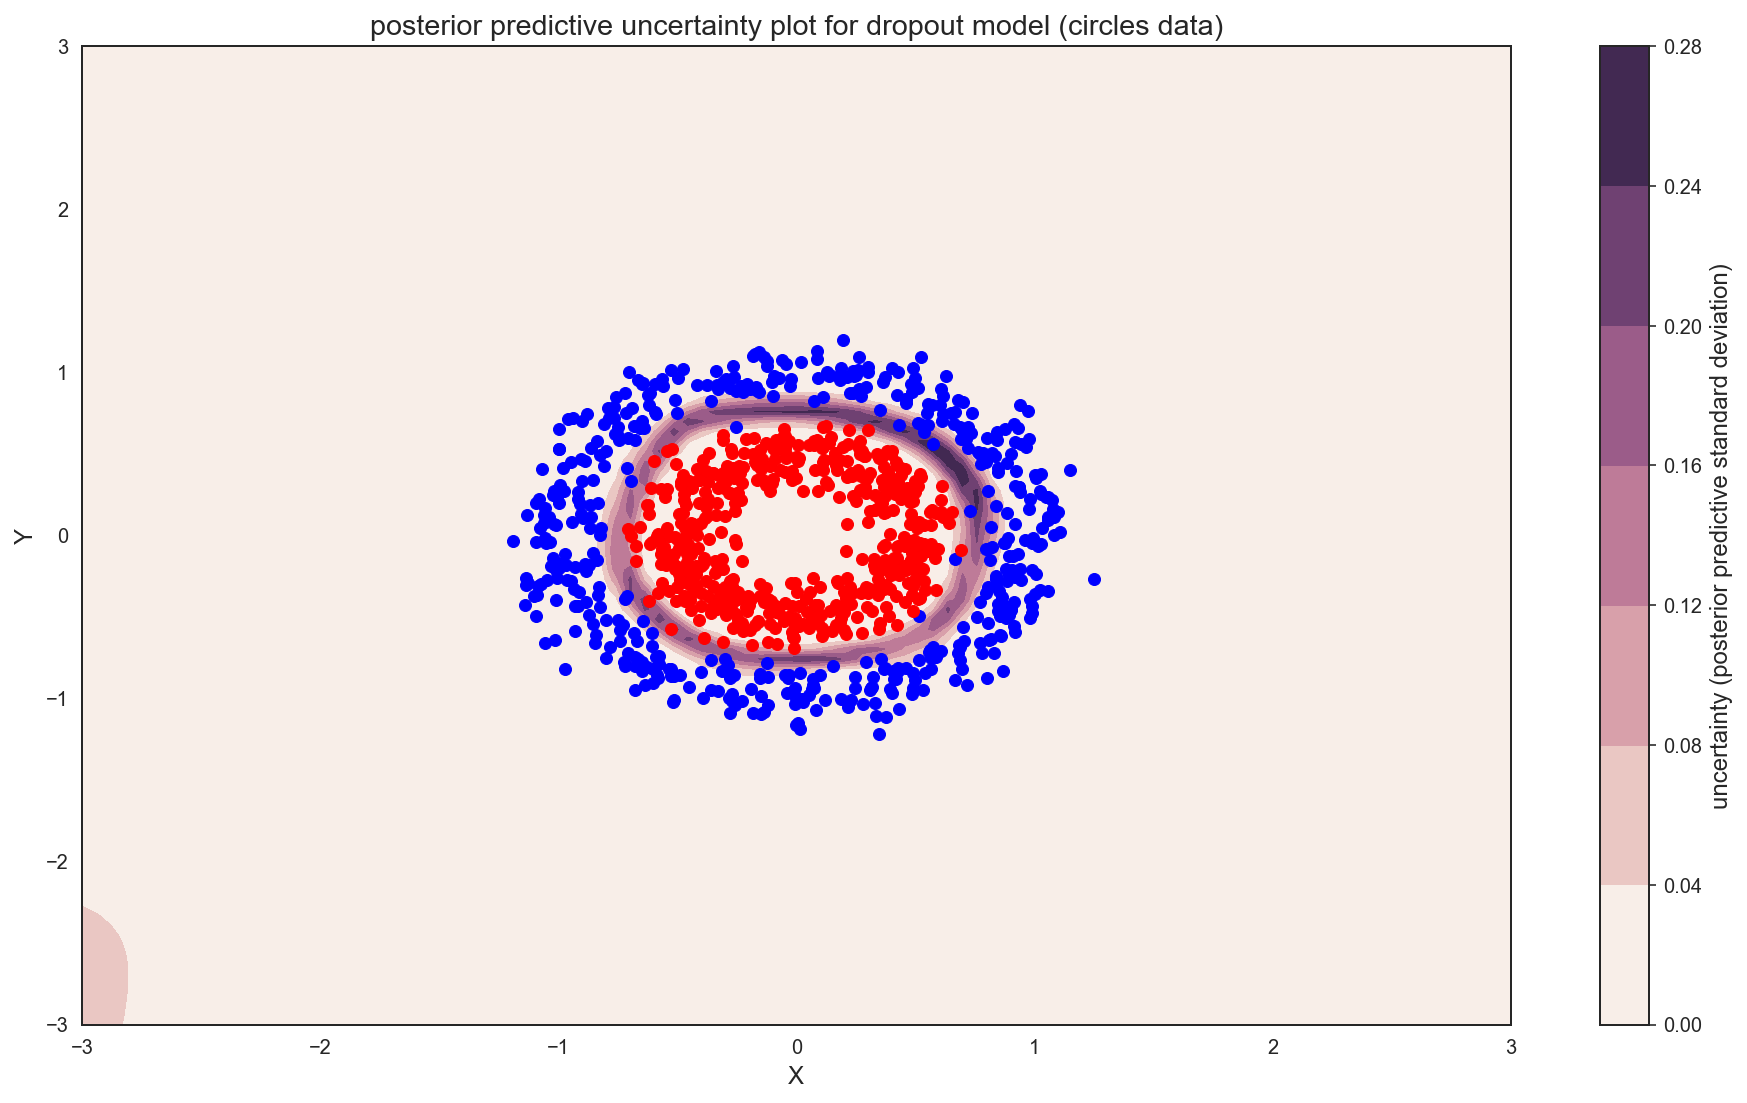

In [33]:
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig, ax = plt.subplots(figsize=(16, 9))
contour = ax.contourf(grid[0], grid[1], np.std(np.array(grid_preds),axis=0).reshape(100, 100), cmap=cmap)
ax.scatter(X_test[Y_test==0, 0], X_test[Y_test==0, 1], color='b')
ax.scatter(X_test[Y_test==1, 0], X_test[Y_test==1, 1], color='r')
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y');
plt.title("posterior predictive uncertainty plot for dropout model ({} data)".format(TOY_DATA_TYPE))
cbar.ax.set_ylabel('uncertainty (posterior predictive standard deviation)')
plt.savefig("{}_uncertainty_plot_dropout.png".format(TOY_DATA_TYPE))

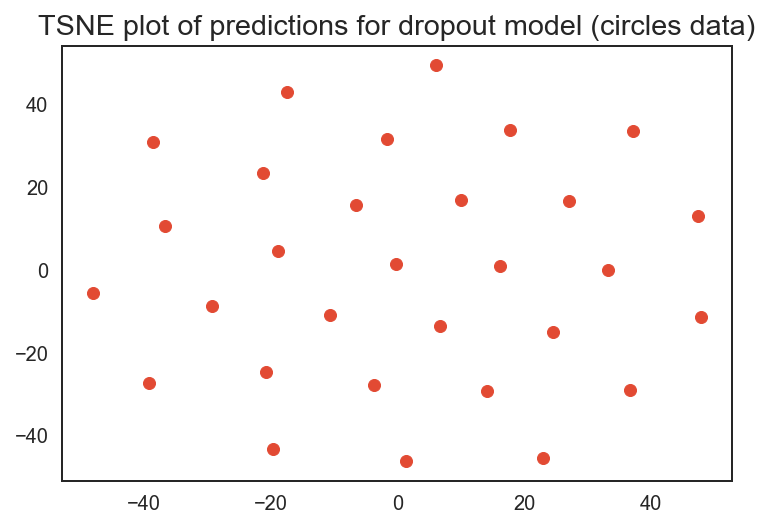

In [34]:
tsne = TSNE(n_components=2)
drop_test_probs_pca = tsne.fit_transform(np.array(dropout_post_predictions).reshape(30, 1000))


plt.scatter(drop_test_probs_pca[:,0], drop_test_probs_pca[:,1])
plt.title("TSNE plot of predictions for dropout model ({} data)".format(TOY_DATA_TYPE))
plt.savefig("{}_tsne_plot_dropout.png".format(TOY_DATA_TYPE))

<a id='random'></a>
## 5. Random Subspace Sampling

In [35]:
models = []
random_weights= []
# iterate over different samples
for i in range(bayes_iters):
    # make a new NN with the same layout
    model2 = get_model(mc=False)
    # add random vector to presaved model weights
    model2.load_weights('initial_model_weights.h5')
    #Added scale to regularize randomness
    weights = [model2.get_weights()[j] + np.random.normal(size = model2.get_weights()[j].shape, scale=0.2) for j in range(len(model.get_weights()))]
    model2.set_weights(weights)
    #Get Dense model weights
    weights = model2.get_weights()
    flat_weight_array = np.array([])
    for weight in weights:
        flat_weight_array = np.concatenate((flat_weight_array, weight.flatten()))
    random_weights.append(flat_weight_array)
    models.append(model2)

In [36]:
random_post_predictions = []
grid_preds = []
random_ood_probs = []

for model in models: 
    y_pred = model.predict(X_test)
    random_post_predictions.append(y_pred)
    pred2 = model.predict(grid_2d)[:,0].flatten()
    grid_preds.append(pred2)
    #Predictions & uncertainty for test points
    ood_prob = model.predict(np.array(test_points))
    random_ood_probs.append(ood_prob)
    
random_posterior_mean_preds = np.mean(np.array(random_post_predictions),axis=0)
random_pred_test_labels = (random_posterior_mean_preds > 0.5).astype(np.int) 
random_acc_score = accuracy_score(Y_test, random_pred_test_labels)
print("Random subspace posterior predictive Test set mean accuracy score for test data: ", random_acc_score)

Random subspace posterior predictive Test set mean accuracy score for test data:  0.992


In [37]:
random_ood_variance = np.std(np.array(random_ood_probs),axis=0)**2

for i in range(len(test_points)):
    print("uncertainty for test point: {} : {}".format(test_points[i], random_ood_variance[i][0]))

uncertainty for test point: (0, 0) : 1.6013214917620644e-05
uncertainty for test point: (0, 2) : 0.0007078656344674528
uncertainty for test point: (0, -2) : 0.00011694464774336666
uncertainty for test point: (2, 0) : 0.00021915463730692863
uncertainty for test point: (-2, 0) : 1.1209728654648643e-05
uncertainty for test point: (-1, 0) : 0.0006528310477733612
uncertainty for test point: (-0.75, 0) : 0.12031090259552002
uncertainty for test point: (-0.5, 0) : 0.00466689420863986
uncertainty for test point: (1, 0) : 0.014572535641491413
uncertainty for test point: (0.75, 0) : 0.09575895220041275
uncertainty for test point: (0.5, 0) : 0.0009487177594564855
uncertainty for test point: (0, 1) : 0.024468617513775826
uncertainty for test point: (0, 0.75) : 0.1094953715801239
uncertainty for test point: (0, 0.5) : 0.006968630477786064
uncertainty for test point: (0, -1) : 0.000972519745118916
uncertainty for test point: (0, -0.75) : 0.10032891482114792
uncertainty for test point: (0, -0.5) : 0.

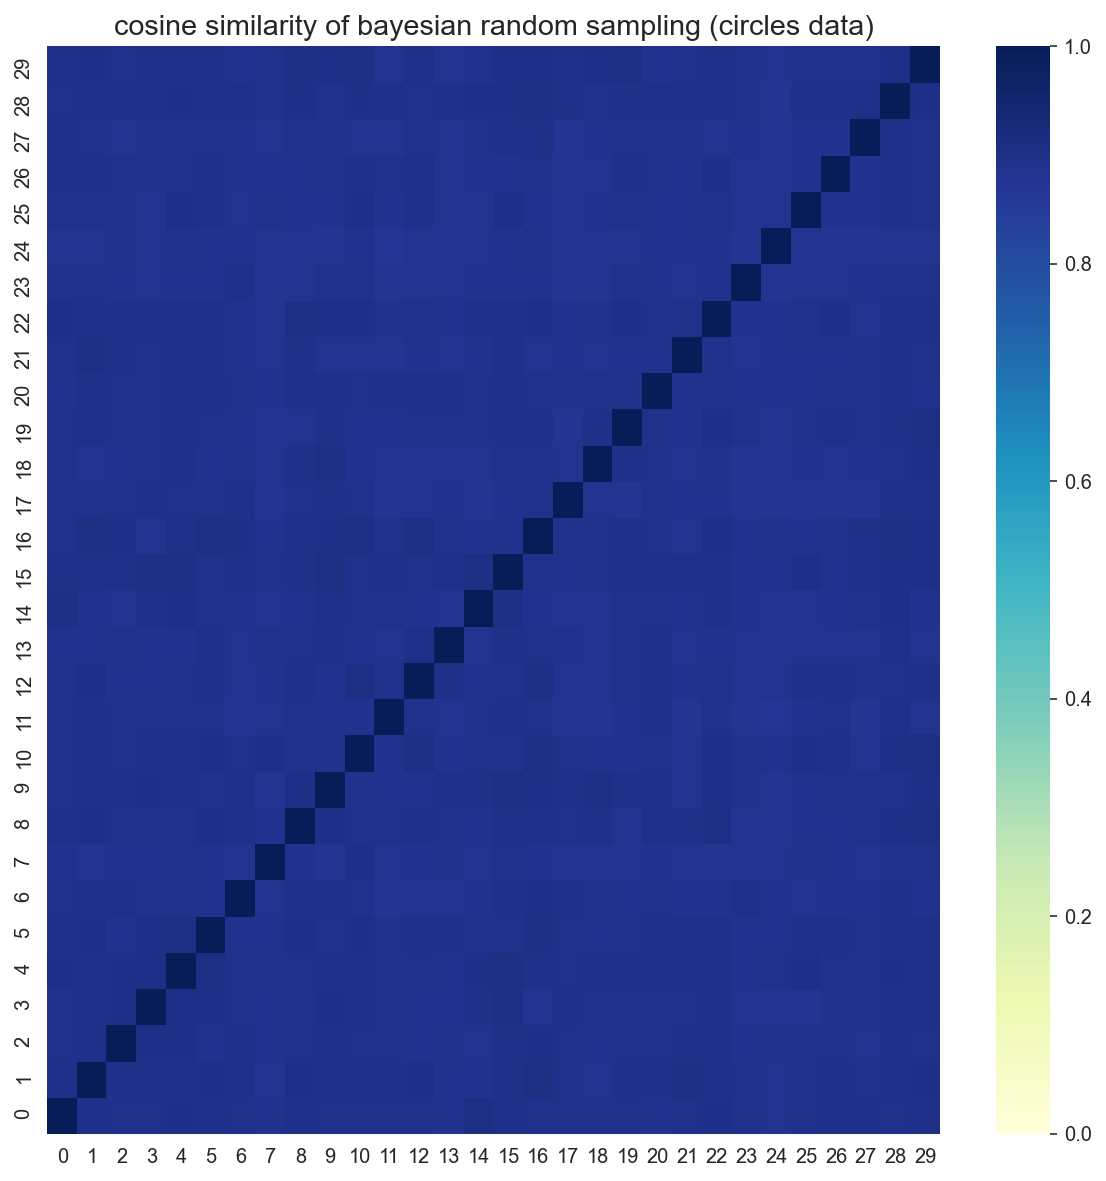

In [38]:
df = pd.DataFrame(np.array(random_weights))

fig = plt.figure(figsize=(10,10))
ax = sns.heatmap(cosine_similarity(df),vmin=0, vmax=1, cmap="YlGnBu") # vmin=0.9, vmax=1
plt.title("cosine similarity of bayesian random sampling ({} data)".format(TOY_DATA_TYPE))
ax.invert_yaxis()
plt.savefig("{}_cosine_similarity_plot_random.png".format(TOY_DATA_TYPE))


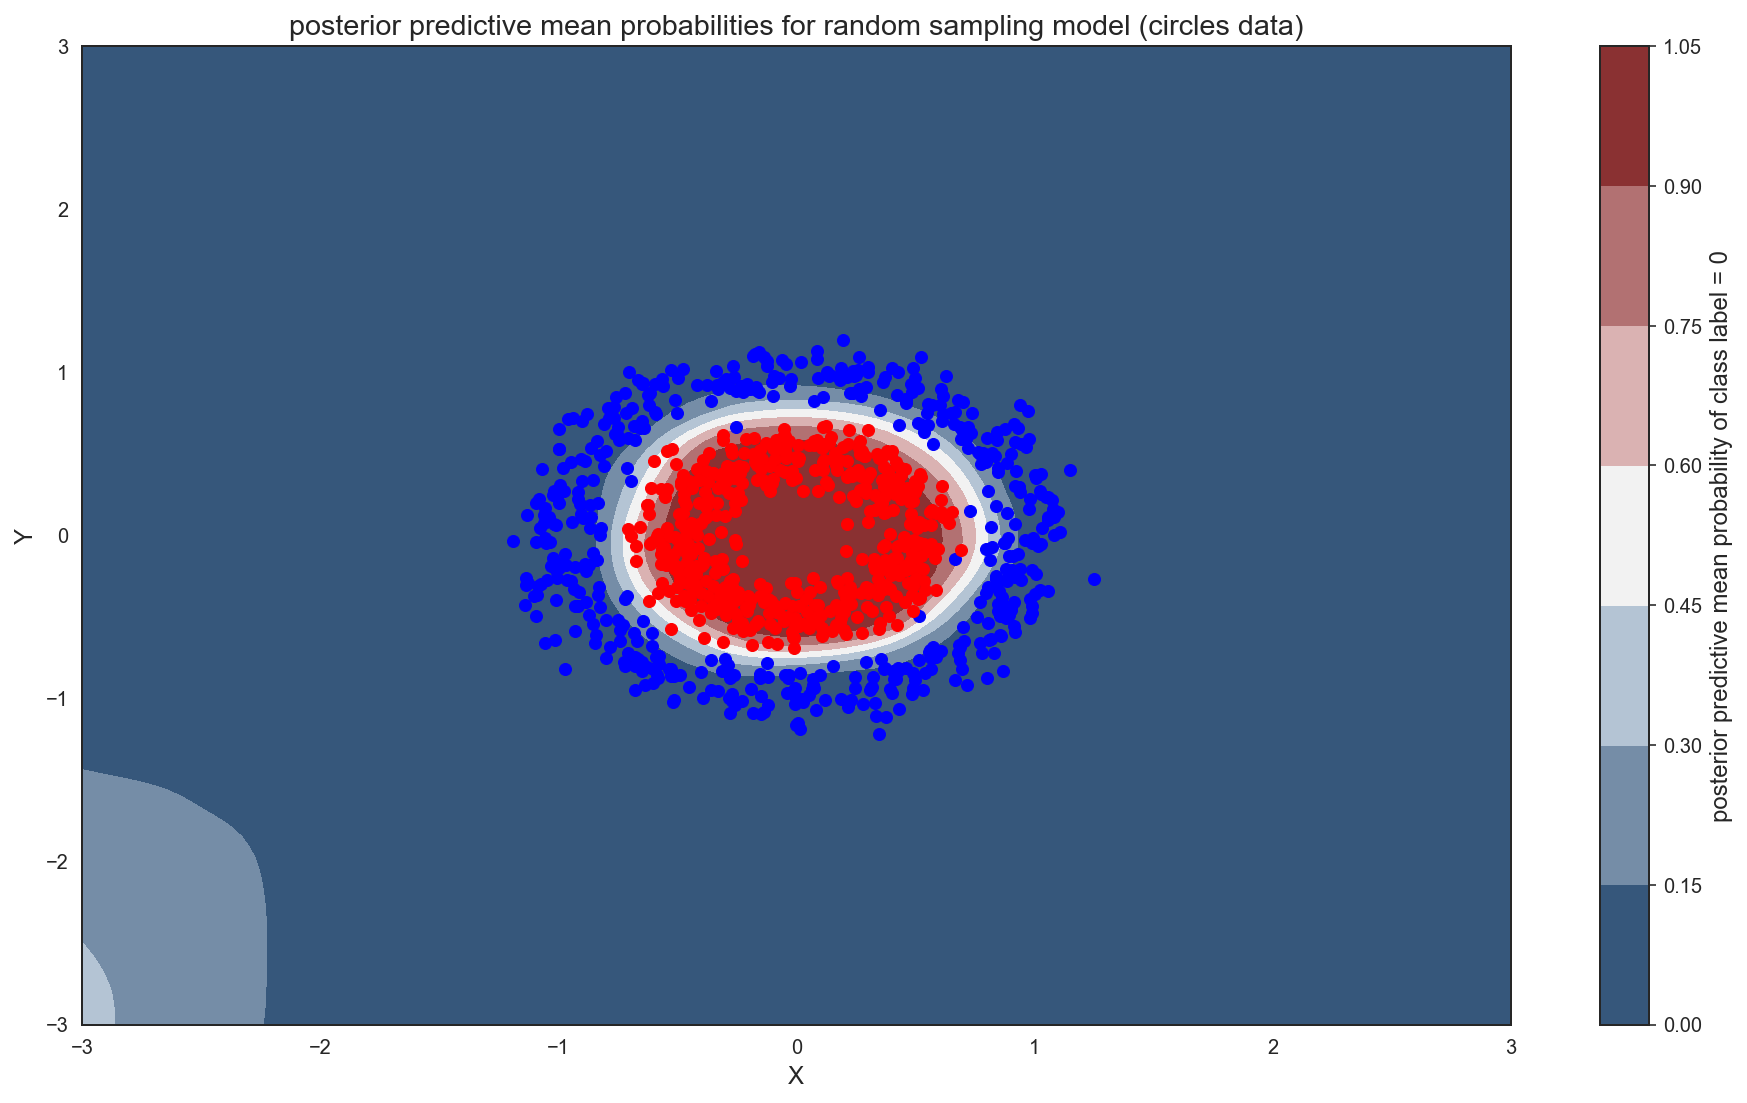

In [39]:
fig, ax = plt.subplots(figsize=(16, 9))
cmap = sns.diverging_palette(250, 12, s=85, l=25, as_cmap=True)
contour = ax.contourf(grid[0], grid[1], np.mean(np.array(grid_preds),axis=0).reshape(100, 100), cmap=cmap)
ax.scatter(X_test[Y_test==0, 0], X_test[Y_test==0, 1], color='b')
ax.scatter(X_test[Y_test==1, 0], X_test[Y_test==1, 1], color='r')
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y');
plt.title("posterior predictive mean probabilities for random sampling model ({} data)".format(TOY_DATA_TYPE))
cbar.ax.set_ylabel('posterior predictive mean probability of class label = 0')
plt.savefig("{}_posterior_predictive_plot_random.png".format(TOY_DATA_TYPE))

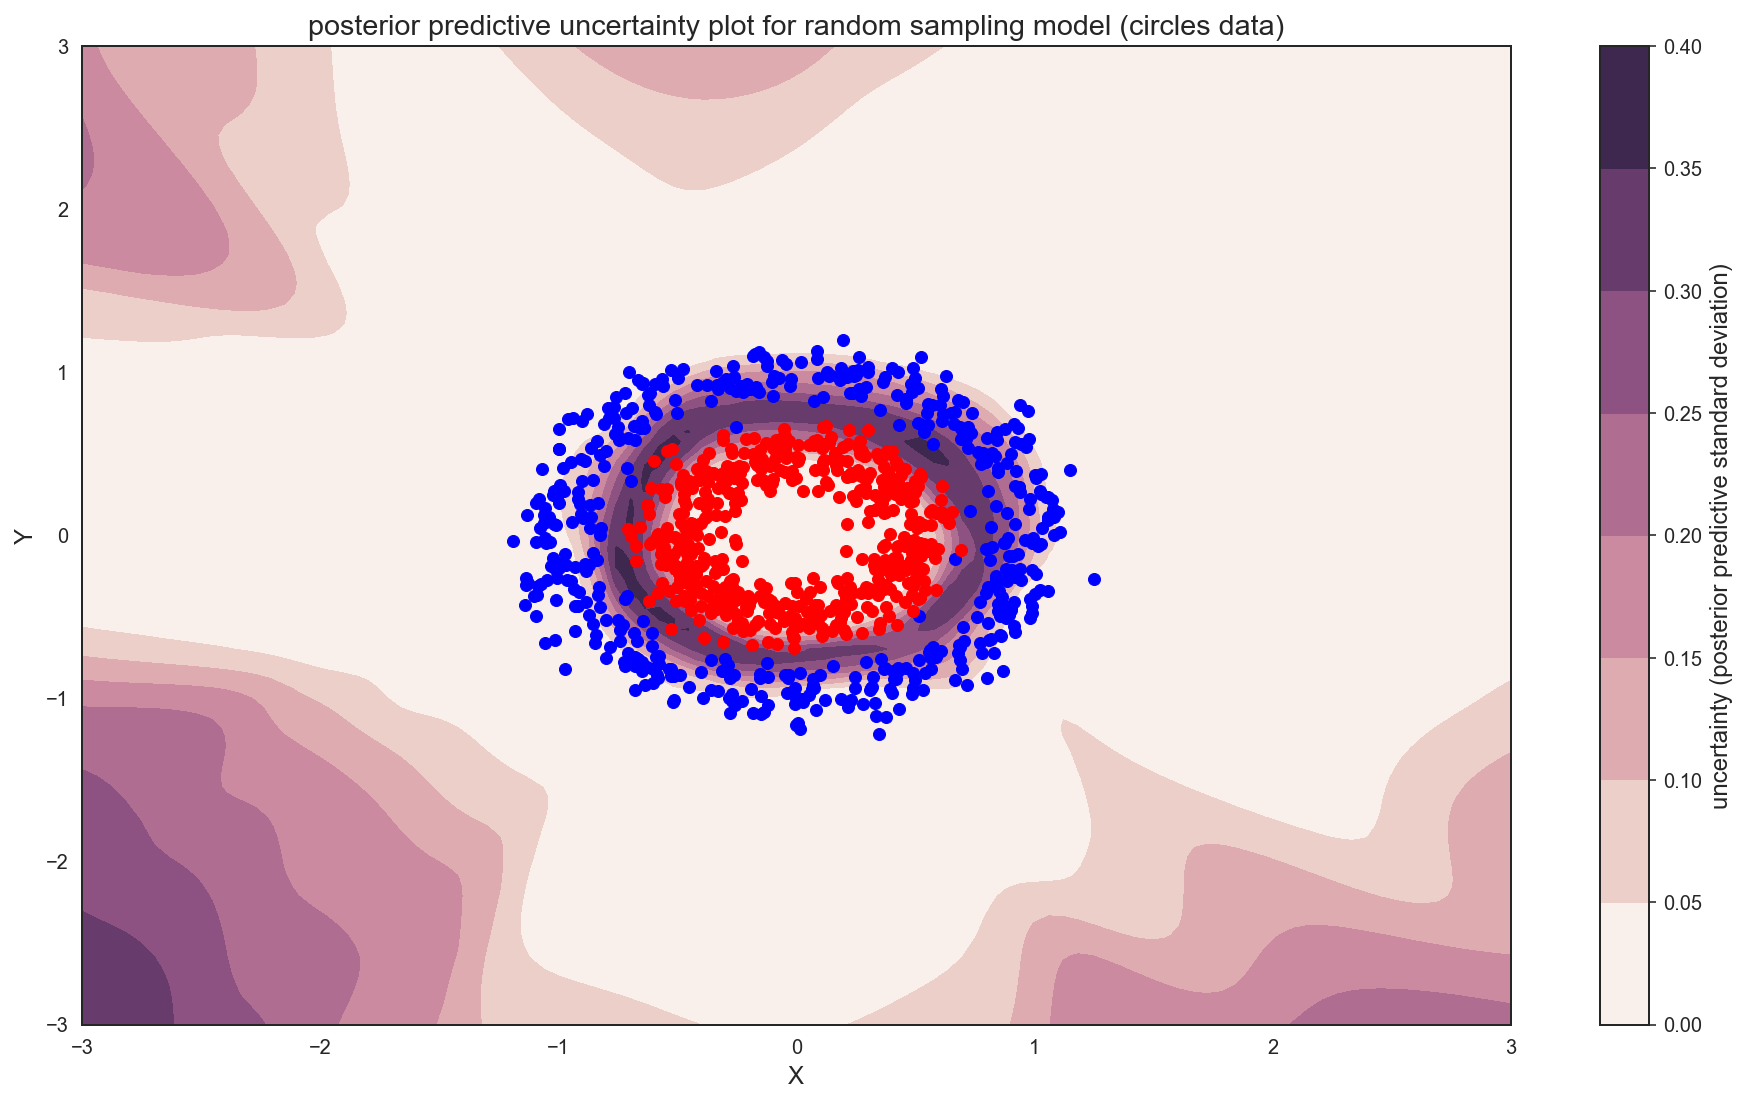

In [40]:
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig, ax = plt.subplots(figsize=(16, 9))
contour = ax.contourf(grid[0], grid[1], np.std(np.array(grid_preds),axis=0).reshape(100, 100), cmap=cmap)
ax.scatter(X_test[Y_test==0, 0], X_test[Y_test==0, 1], color='b')
ax.scatter(X_test[Y_test==1, 0], X_test[Y_test==1, 1], color='r')
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y');
plt.title("posterior predictive uncertainty plot for random sampling model ({} data)".format(TOY_DATA_TYPE))
cbar.ax.set_ylabel('uncertainty (posterior predictive standard deviation)')
plt.savefig("{}_uncertainty_plot_random.png".format(TOY_DATA_TYPE))

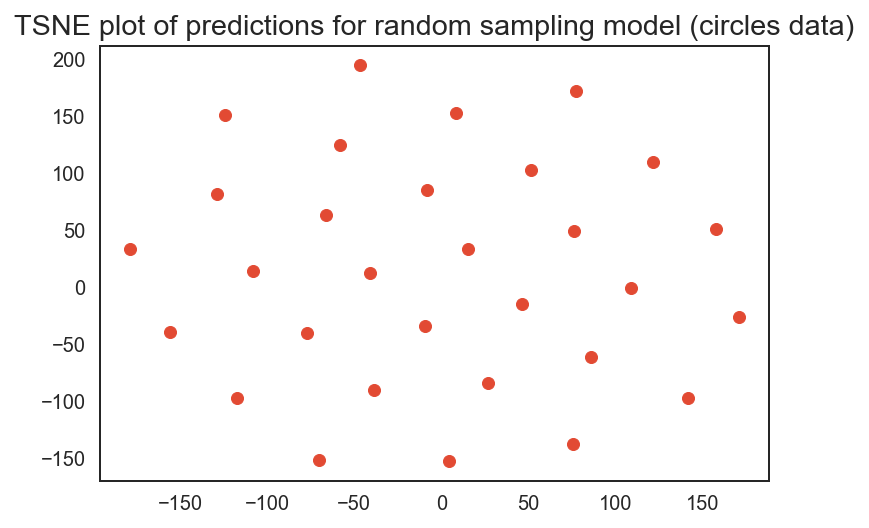

In [41]:
tsne = TSNE(n_components=2)
rand_test_probs_pca = tsne.fit_transform(np.array(random_post_predictions).reshape(30, 1000))


plt.scatter(rand_test_probs_pca[:,0], rand_test_probs_pca[:,1])
plt.title("TSNE plot of predictions for random sampling model ({} data)".format(TOY_DATA_TYPE))
plt.savefig("{}_tsne_plot_random.png".format(TOY_DATA_TYPE))

<a id='hmc'></a>
## 6. HMC

In [42]:
def construct_nn(ann_input, ann_output):
    n_hidden1 = 64
    n_hidden2 = 8

    # Initialize random weights between each layer
    model = get_model(mc=False)
    model.load_weights('initial_model_weights.h5')
    ws = model.get_weights()
    init_1 = ws[0].astype(floatX)
    init_2 = ws[2].astype(floatX)
    init_out = ws[4].flatten().astype(floatX)
    init_b1 = ws[1].astype(floatX)
    init_b2 = ws[3].astype(floatX)
    init_bout = ws[5].astype(floatX)

    with pm.Model() as neural_network:
        # Trick: Turn inputs and outputs into shared variables using the data container pm.Data
        # It's still the same thing, but we can later change the values of the shared variable
        # (to switch in the test-data later) and pymc3 will just use the new data.
        # Kind-of like a pointer we can redirect.
        # For more info, see: http://deeplearning.net/software/theano/library/compile/shared.html
        ann_input = pm.Data('ann_input', ann_input)
        ann_output = pm.Data('ann_output', ann_output)

        # Weights from input to hidden layer
        weights_in_1 = pm.Normal('w_in_1', 0, sigma=1,
                                 shape=(X.shape[1], n_hidden1),
                                 testval=init_1)
        biases_in_1 = pm.Normal('b_in_1', 0, sigma=1,
                                 shape=(n_hidden1,),
                                 testval=init_b1)

        # Weights from 1st to 2nd layer
        weights_1_2 = pm.Normal('w_1_2', 0, sigma=1,
                                shape=(n_hidden1, n_hidden2),
                                testval=init_2)
        biases_1_2 = pm.Normal('b_1_2', 0, sigma=1,
                                 shape=(n_hidden2,),
                                 testval=init_b2)

        # Weights from hidden layer to output
        weights_2_out = pm.Normal('w_2_out', 0, sigma=1,
                                  shape=(n_hidden2,),
                                  testval=init_out)
        biases_2_out = pm.Normal('b_3_out', 0, sigma=1,
                                 shape=(1,),
                                 testval=init_bout)

        # Build neural-network using tanh activation function
        act_1 = pm.math.tanh(pm.math.dot(ann_input,
                                         weights_in_1)+biases_in_1)
        act_2 = pm.math.tanh(pm.math.dot(act_1,
                                         weights_1_2)+biases_1_2)
        act_out = pm.math.sigmoid(pm.math.dot(act_2,
                                              weights_2_out)+biases_2_out)

        # Binary classification -> Bernoulli likelihood
        out = pm.Bernoulli('out',
                           act_out,
                           observed=ann_output,
                           total_size=Y_train.shape[0] # IMPORTANT for minibatches
                          )
    return neural_network

neural_network = construct_nn(X_train, Y_train)

In [43]:
from pymc3.theanof import set_tt_rng, MRG_RandomStreams
set_tt_rng(MRG_RandomStreams(42))

In [44]:
with neural_network:
    steps = pm.NUTS()
    #use the specify sampler to sample from the posterior of the model
    trace = pm.sample(5000, step=steps, tune=1000, chains=1)

Sequential sampling (1 chains in 1 job)
NUTS: [b_3_out, w_2_out, b_1_2, w_1_2, b_in_1, w_in_1]
Sampling chain 0, 12 divergences: 100%|██████████| 6000/6000 [1:14:12<00:00,  1.35it/s]
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


In [45]:
pm.set_data(new_data={'ann_input': X_test, 'ann_output': Y_test}, model=neural_network)
ppc = pm.sample_posterior_predictive(trace, samples=500, progressbar=False, model=neural_network)

In [46]:
pred = ppc["out"].mean(axis=0) > 0.5

In [47]:
print('Test Set Accuracy = {}%'.format((Y_test == pred).mean() * 100))

Test Set Accuracy = 99.1%


In [48]:
pm.set_data(new_data={'ann_input': np.array(test_points), 'ann_output': np.ones(len(test_points), dtype=np.int8)}, model=neural_network)
ppc = pm.sample_posterior_predictive(trace, samples=500, progressbar=False, model=neural_network)
ood_variance = np.std(ppc["out"],axis=0)**2

for i in range(len(test_points)):
    print("uncertainty for test point: {} : {}".format(test_points[i], ood_variance[i]))

uncertainty for test point: (0, 0) : 0.0
uncertainty for test point: (0, 2) : 0.023423999999999986
uncertainty for test point: (0, -2) : 0.005964000000000059
uncertainty for test point: (2, 0) : 0.023424000000000132
uncertainty for test point: (-2, 0) : 0.019600000000000183
uncertainty for test point: (-1, 0) : 0.005964000000000043
uncertainty for test point: (-0.75, 0) : 0.19239999999999965
uncertainty for test point: (-0.5, 0) : 0.005964000000000084
uncertainty for test point: (1, 0) : 0.00793600000000005
uncertainty for test point: (0.75, 0) : 0.2499360000000004
uncertainty for test point: (0.5, 0) : 0.0
uncertainty for test point: (0, 1) : 0.005964000000000063
uncertainty for test point: (0, 0.75) : 0.24422400000000158
uncertainty for test point: (0, 0.5) : 0.0019960000000000004
uncertainty for test point: (0, -1) : 0.001996000000000004
uncertainty for test point: (0, -0.75) : 0.23745599999999845
uncertainty for test point: (0, -0.5) : 0.0


In [49]:
pm.set_data(new_data={'ann_input': grid_2d, 'ann_output': dummy_out}, model=neural_network)
ppc = pm.sample_posterior_predictive(trace, samples=500, progressbar=False, model=neural_network)

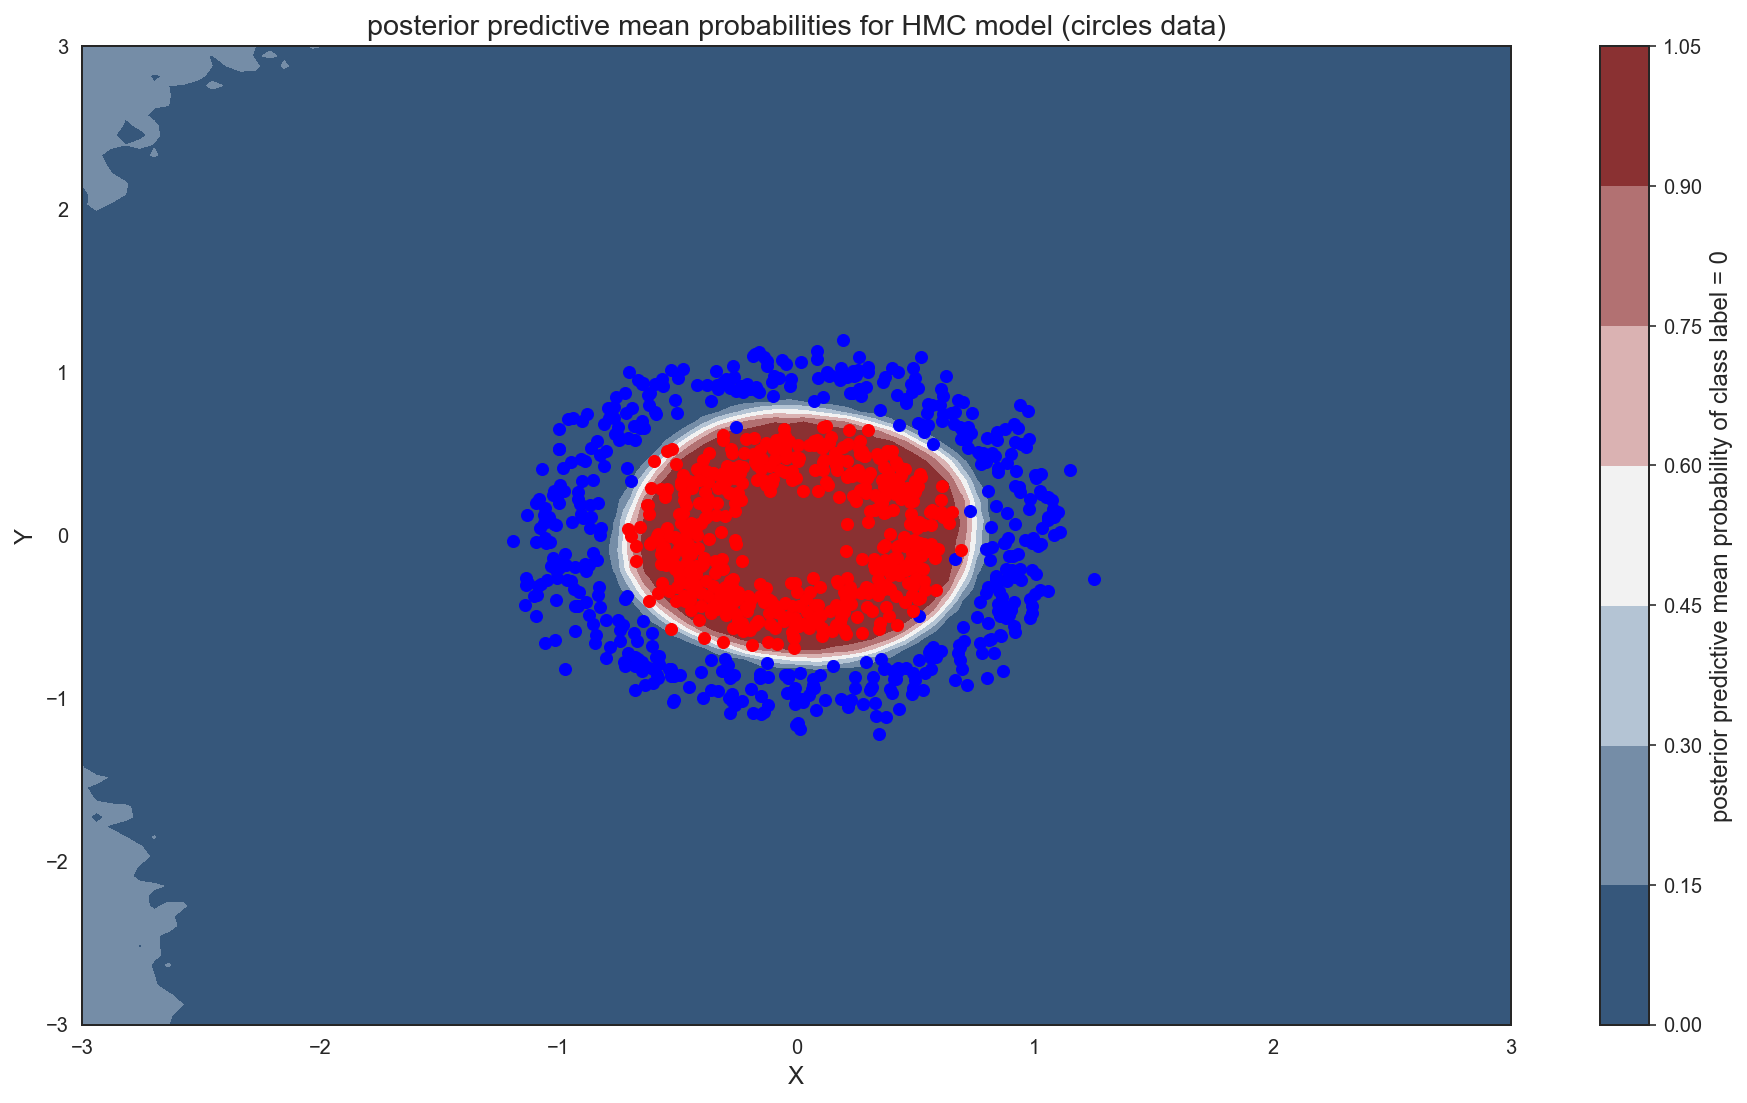

In [50]:
cmap = sns.diverging_palette(250, 12, s=85, l=25, as_cmap=True)
fig, ax = plt.subplots(figsize=(16, 9))
contour = ax.contourf(grid[0], grid[1], ppc["out"].mean(axis=0).reshape(100, 100), cmap=cmap)
ax.scatter(X_test[Y_test==0, 0], X_test[Y_test==0, 1], color='b')
ax.scatter(X_test[Y_test==1, 0], X_test[Y_test==1, 1], color='r')
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y');
plt.title("posterior predictive mean probabilities for HMC model ({} data)".format(TOY_DATA_TYPE))
cbar.ax.set_ylabel('posterior predictive mean probability of class label = 0')
plt.savefig("{}_posterior_predictive_plot_hmc.png".format(TOY_DATA_TYPE))

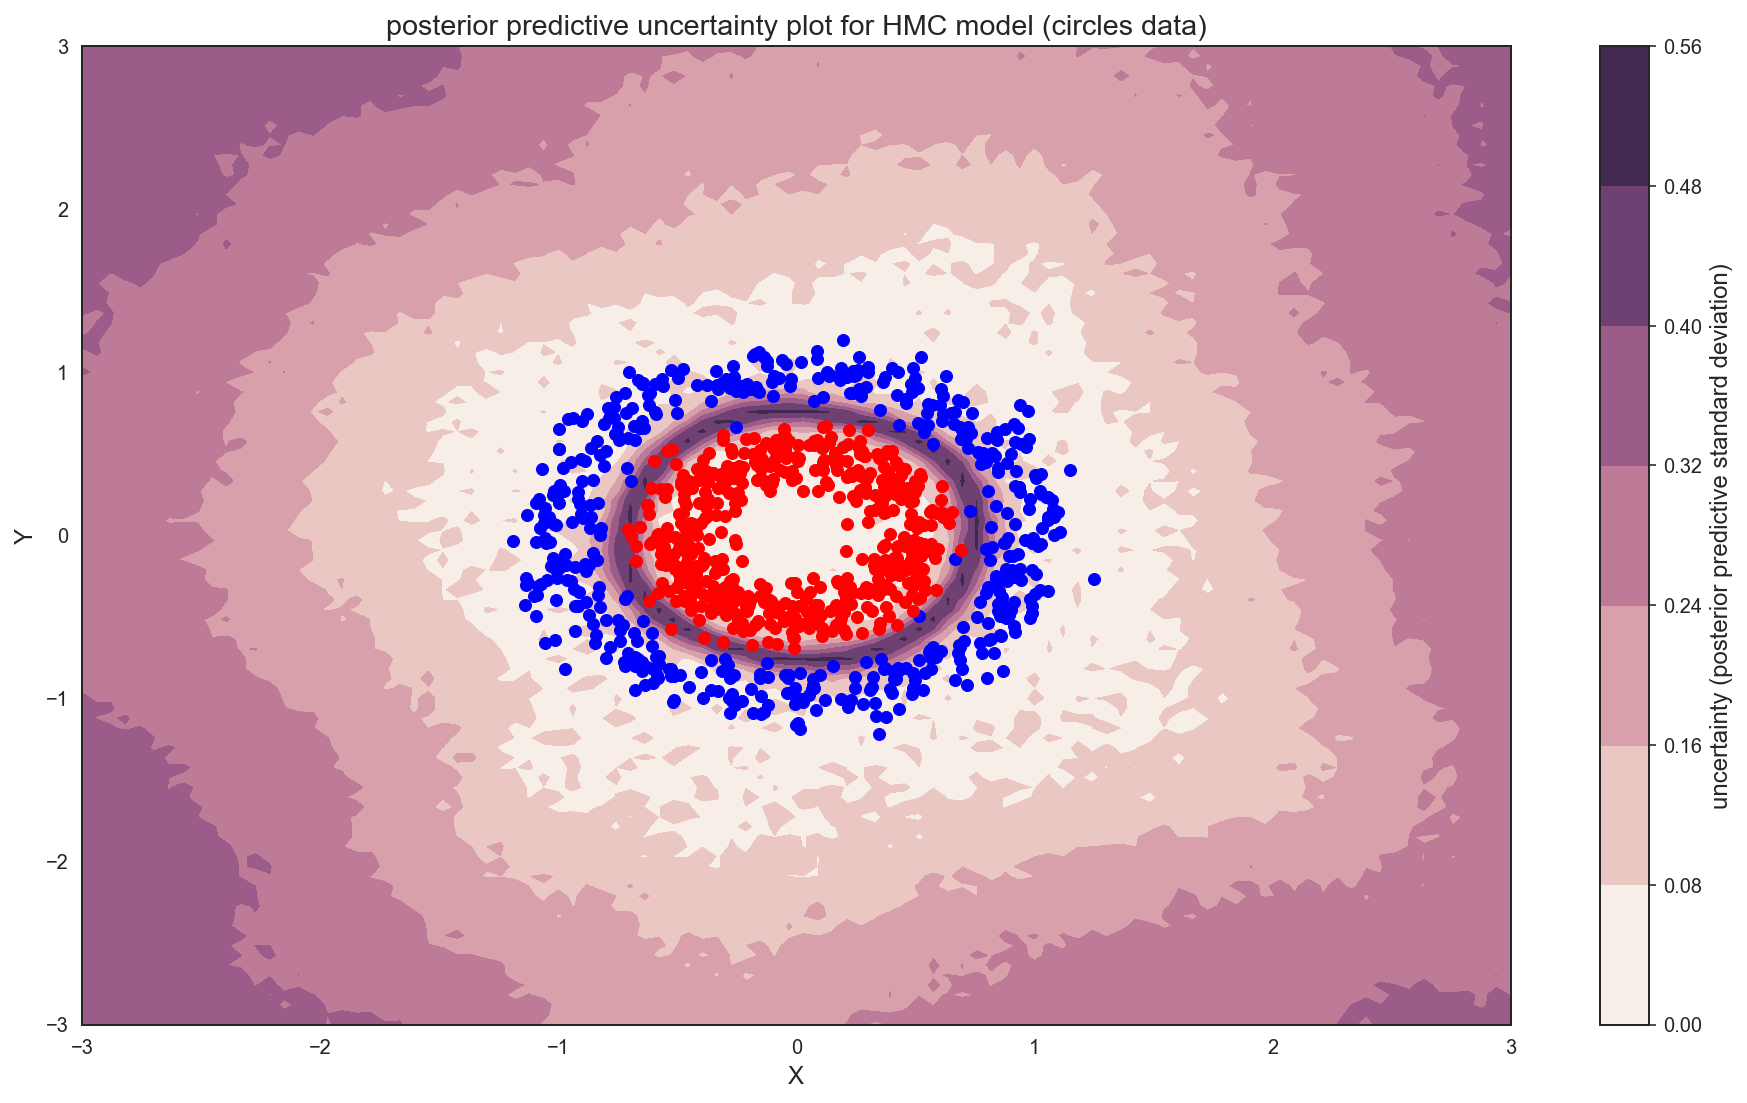

In [51]:
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig, ax = plt.subplots(figsize=(16, 9))
contour = ax.contourf(grid[0], grid[1], ppc["out"].std(axis=0).reshape(100, 100), cmap=cmap)
ax.scatter(X_test[Y_test==0, 0], X_test[Y_test==0, 1], color='b')
ax.scatter(X_test[Y_test==1, 0], X_test[Y_test==1, 1], color='r')
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y');
plt.title("posterior predictive uncertainty plot for HMC model ({} data)".format(TOY_DATA_TYPE))
cbar.ax.set_ylabel('uncertainty (posterior predictive standard deviation)')
plt.savefig("{}_uncertainty_plot_hmc.png".format(TOY_DATA_TYPE))

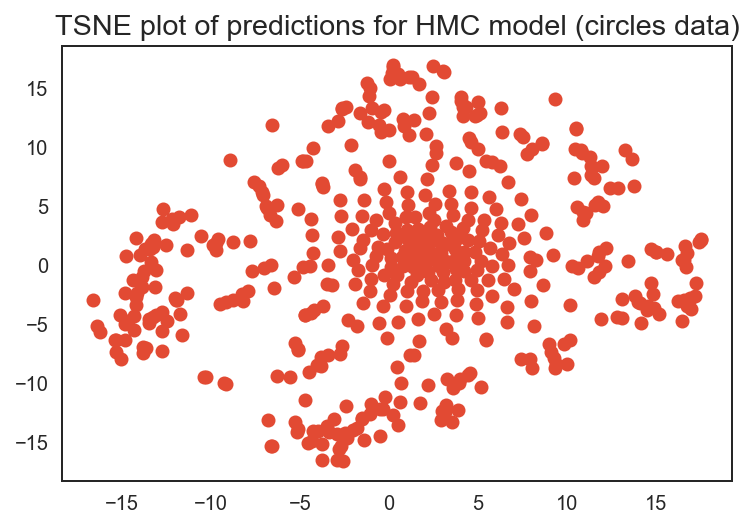

In [52]:
pm.set_data(new_data={'ann_input': grid_2d, 'ann_output': dummy_out}, model=neural_network)
ppc = pm.sample_posterior_predictive(trace, samples=500, progressbar=False, model=neural_network)["out"]
tsne = TSNE(n_components=2)
ppc_pca = tsne.fit_transform(ppc)


plt.plot(ppc_pca[:,0], ppc_pca[:,1], linestyle = "", marker = "o")
plt.title("TSNE plot of predictions for HMC model ({} data)".format(TOY_DATA_TYPE))
plt.savefig("{}_tsne_plot_hmc.png".format(TOY_DATA_TYPE))

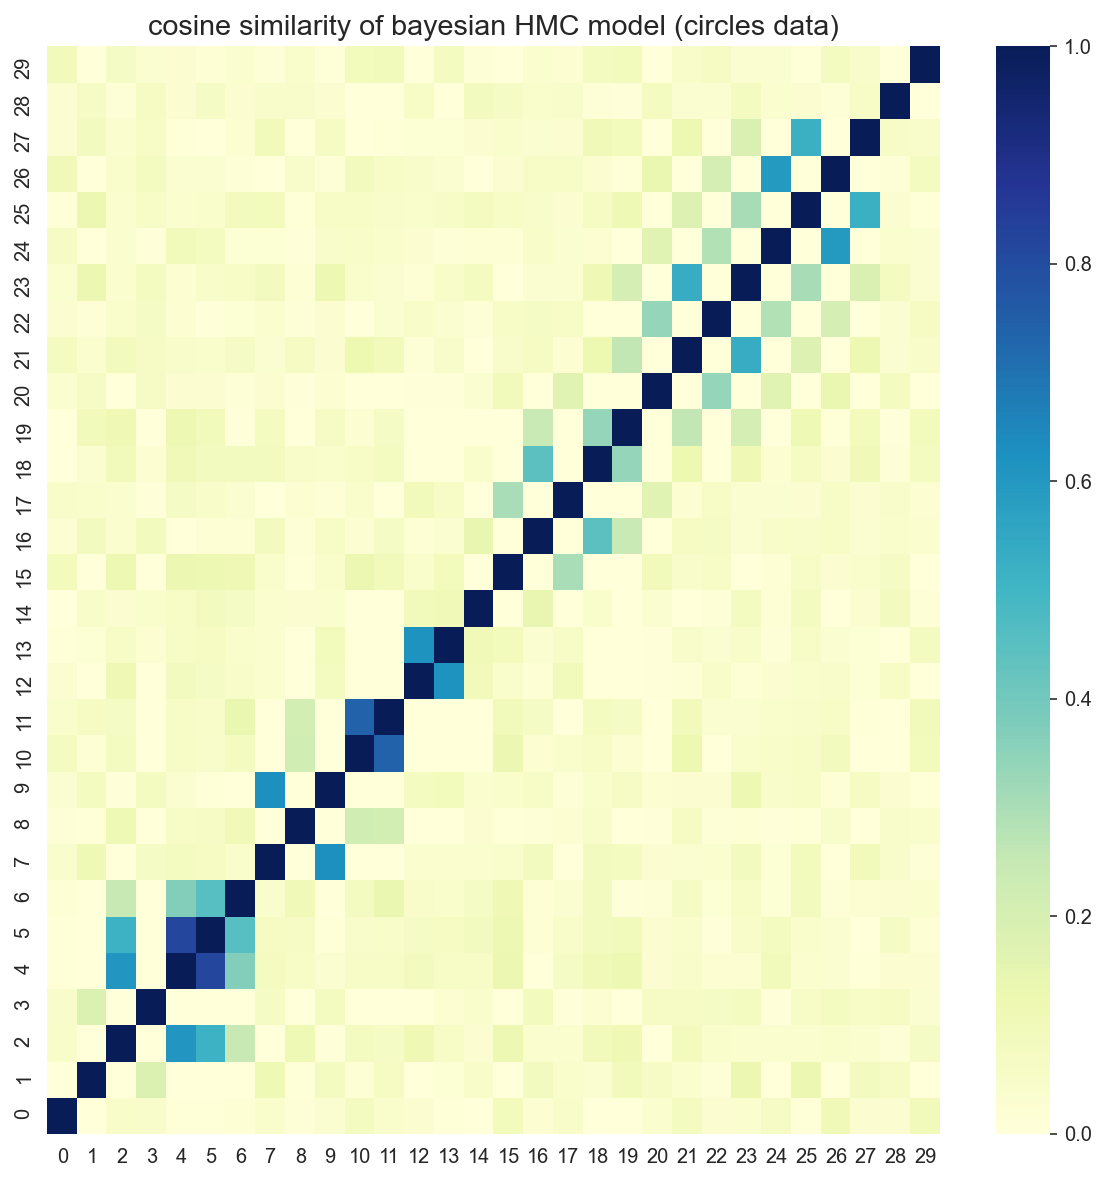

In [53]:
combined = trace["w_in_1"].reshape(-1, 64*2)
combined = np.concatenate((combined, trace["w_1_2"].reshape(-1, 64*8)), axis=1)
combined = np.concatenate((combined, trace["w_2_out"]), axis=1)
combined = np.concatenate((combined, trace["b_in_1"]), axis=1)
combined = np.concatenate((combined, trace["b_1_2"]), axis=1)
combined = np.concatenate((combined, trace["b_3_out"]), axis=1)

df = pd.DataFrame(np.array(combined)[-30:])

fig = plt.figure(figsize=(10,10))
ax = sns.heatmap(cosine_similarity(df),vmin=0, vmax=1, cmap="YlGnBu") # vmin=0.9, vmax=1
plt.title("cosine similarity of bayesian HMC model ({} data)".format(TOY_DATA_TYPE))
ax.invert_yaxis()
plt.savefig("{}_cos_similarity_plot_hmc.png".format(TOY_DATA_TYPE))

<a id='advi'></a>
## 7. ADVI

In [54]:
neural_network = construct_nn(X_train, Y_train)

In [55]:
with neural_network:
    steps = pm.ADVI()
    #use the specify sampler to sample from the posterior of the model
    approx = pm.fit(n=30000, method=steps)

Average Loss = 620.03: 100%|██████████| 30000/30000 [01:08<00:00, 435.01it/s]
Finished [100%]: Average Loss = 619.77


In [56]:
# create symbolic input
x_sym = T.matrix('X_test')
# symbolic number of samples is supported, we build vectorized posterior on the fly
n_sym = T.iscalar('n')
# Do not forget test_values or set theano.config.compute_test_value = 'off'
x_sym.tag.test_value = np.empty_like(X_test)
n_sym.tag.test_value = X_test.shape[1]
_sample_proba = approx.sample_node(neural_network.out.distribution.p,
                                   size=n_sym,
                                   more_replacements={neural_network['ann_input']: x_sym})
# Efficient vectorized form of sampling is used
sample_proba = theano.function([x_sym, n_sym], _sample_proba)
pred = (sample_proba(X_test, 500).mean(0) > 0.5) * 1
print('Test Set Accuracy = {}%'.format((Y_test == pred).mean() * 100))

Test Set Accuracy = 98.9%


In [57]:
ppc = sample_proba(test_points ,500)
ood_variance = np.std(ppc,axis=0)**2

for i in range(len(test_points)):
    print("uncertainty for test point: {} : {}".format(test_points[i], ood_variance[i]))

uncertainty for test point: (0, 0) : 0.0013335950656750447
uncertainty for test point: (0, 2) : 0.02848733138583136
uncertainty for test point: (0, -2) : 0.054458929908839424
uncertainty for test point: (2, 0) : 0.025811564952307443
uncertainty for test point: (-2, 0) : 0.03722690305269878
uncertainty for test point: (-1, 0) : 0.05481854731016957
uncertainty for test point: (-0.75, 0) : 0.101129854116061
uncertainty for test point: (-0.5, 0) : 0.043255422928768675
uncertainty for test point: (1, 0) : 0.05803755418096433
uncertainty for test point: (0.75, 0) : 0.09926607998458013
uncertainty for test point: (0.5, 0) : 0.043755379944288963
uncertainty for test point: (0, 1) : 0.059161307661379246
uncertainty for test point: (0, 0.75) : 0.0972356642349845
uncertainty for test point: (0, 0.5) : 0.0360872216796245
uncertainty for test point: (0, -1) : 0.05417930271394484
uncertainty for test point: (0, -0.75) : 0.09485059308040518
uncertainty for test point: (0, -0.5) : 0.03884016861465743


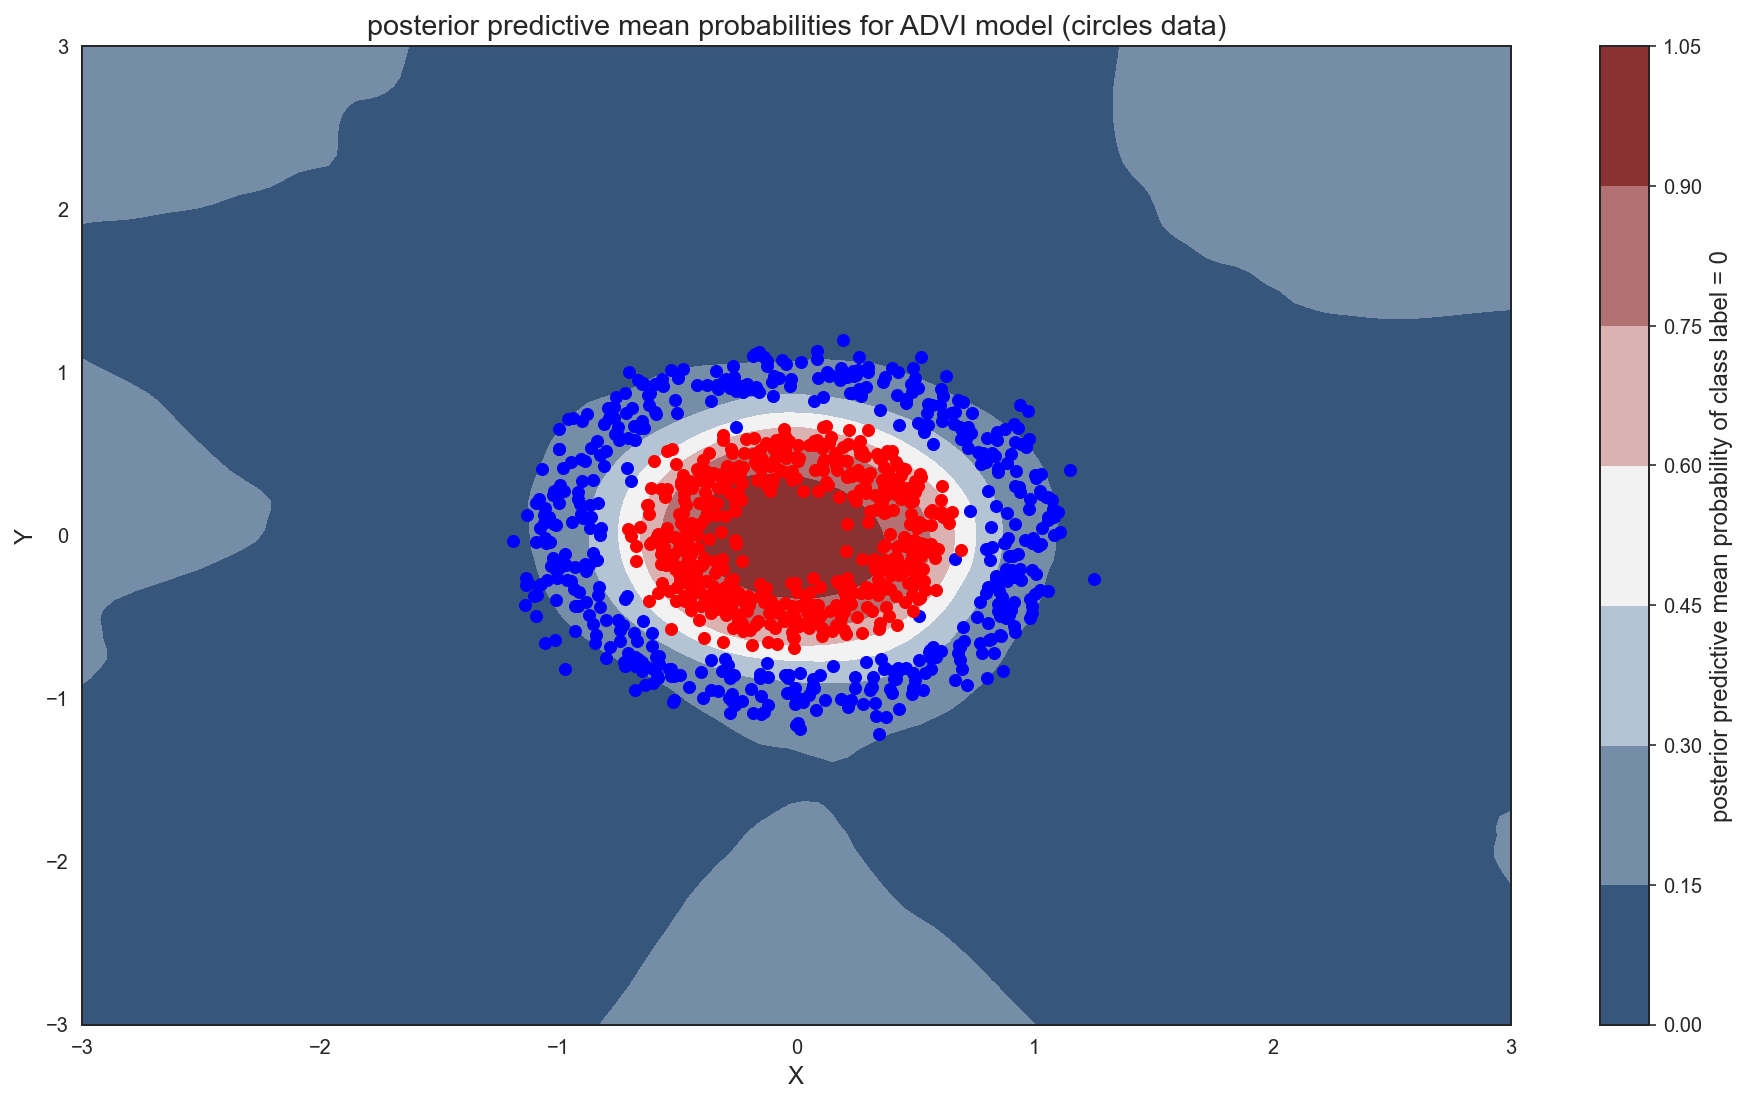

In [58]:
# populate grid with average predictions
ppc = sample_proba(grid_2d ,500)
cmap = sns.diverging_palette(250, 12, s=85, l=25, as_cmap=True)
fig, ax = plt.subplots(figsize=(16, 9))
contour = ax.contourf(grid[0], grid[1], ppc.mean(axis=0).reshape(100, 100), cmap=cmap)
ax.scatter(X_test[Y_test==0, 0], X_test[Y_test==0, 1], color='b')
ax.scatter(X_test[Y_test==1, 0], X_test[Y_test==1, 1], color='r')
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y');
plt.title("posterior predictive mean probabilities for ADVI model ({} data)".format(TOY_DATA_TYPE))
cbar.ax.set_ylabel('posterior predictive mean probability of class label = 0')
plt.savefig("{}_posterior_predictive_plot_advi.png".format(TOY_DATA_TYPE))

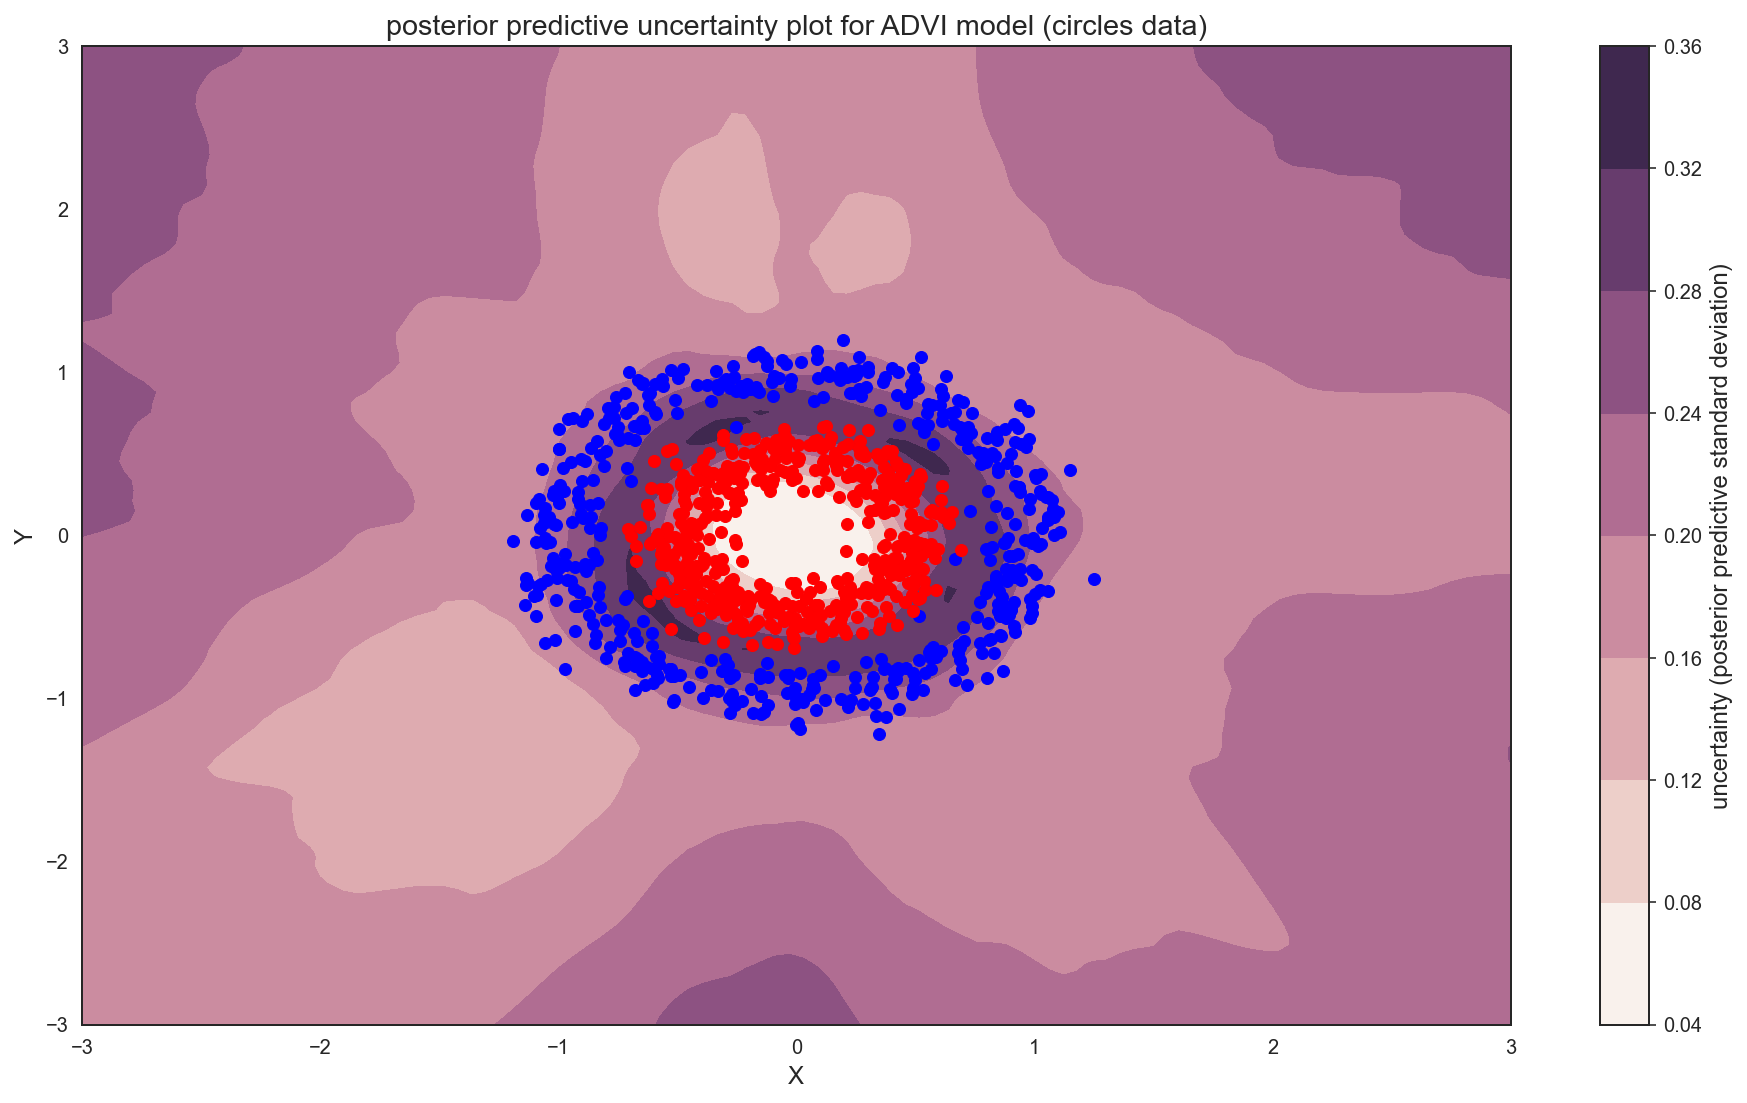

In [59]:
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig, ax = plt.subplots(figsize=(16, 9))
contour = ax.contourf(grid[0], grid[1], ppc.std(axis=0).reshape(100, 100), cmap=cmap)
ax.scatter(X_test[Y_test==0, 0], X_test[Y_test==0, 1], color='b')
ax.scatter(X_test[Y_test==1, 0], X_test[Y_test==1, 1], color='r')
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y');
plt.title("posterior predictive uncertainty plot for ADVI model ({} data)".format(TOY_DATA_TYPE))
cbar.ax.set_ylabel('uncertainty (posterior predictive standard deviation)')
plt.savefig("{}_uncertainty_plot_advi.png".format(TOY_DATA_TYPE))

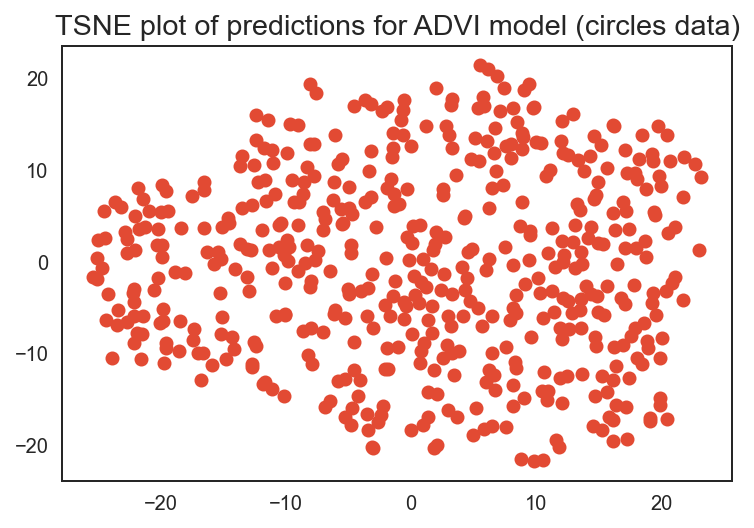

In [60]:
ppc = sample_proba(X_test ,500)
tsne = TSNE(n_components=2)
ppc_pca = tsne.fit_transform(ppc)


plt.plot(ppc_pca[:,0], ppc_pca[:,1], linestyle = "", marker = "o")
plt.title("TSNE plot of predictions for ADVI model ({} data)".format(TOY_DATA_TYPE))
plt.savefig("{}_tsne_plot_advi.png".format(TOY_DATA_TYPE))

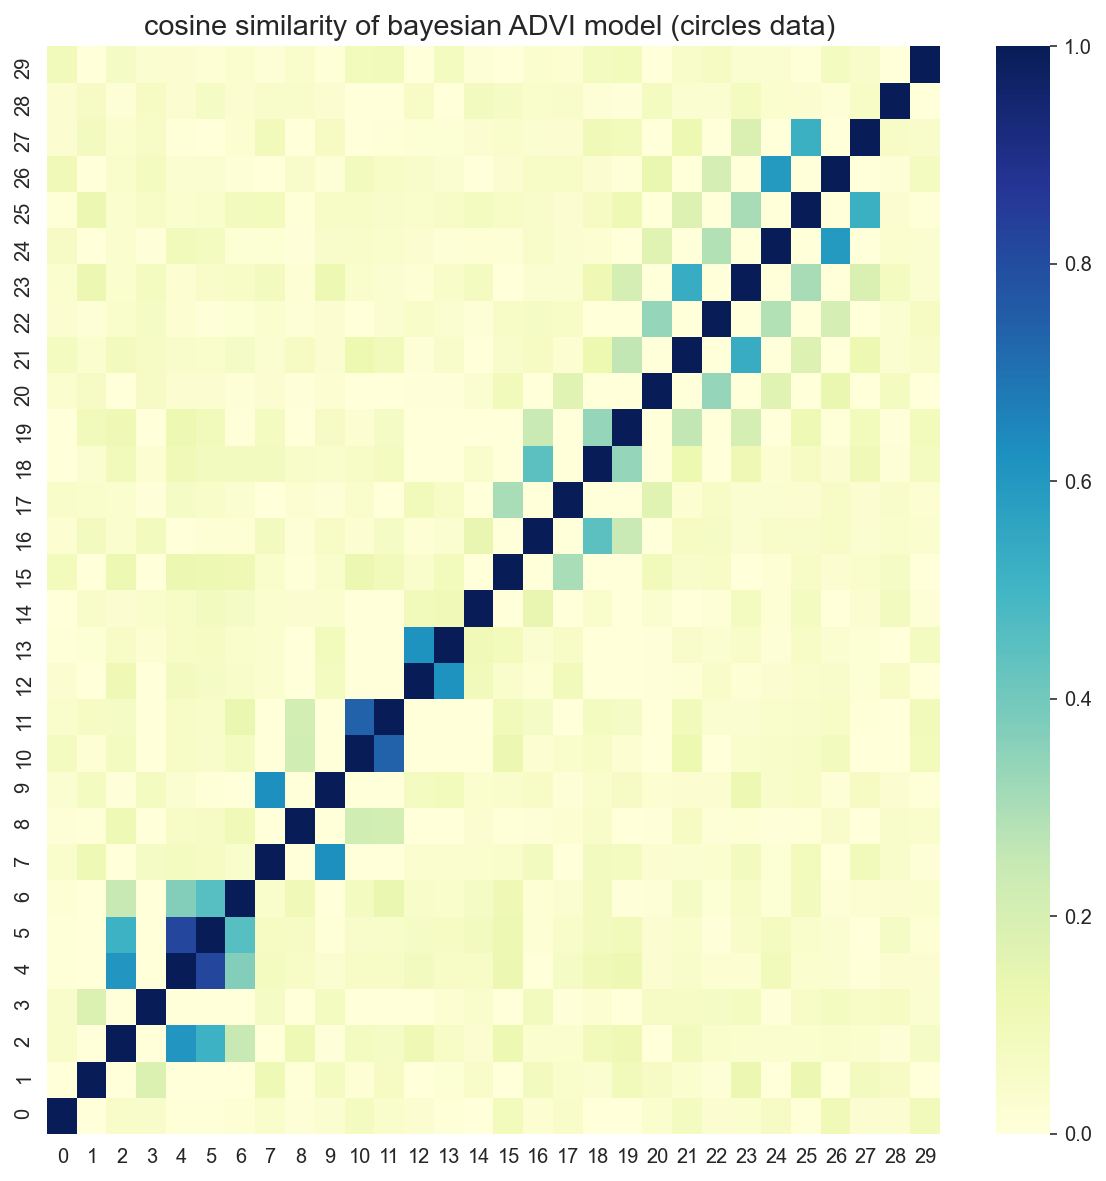

In [61]:
combined = trace["w_in_1"].reshape(-1, 64*2)
combined = np.concatenate((combined, trace["w_1_2"].reshape(-1, 64*8)), axis=1)
combined = np.concatenate((combined, trace["w_2_out"]), axis=1)
combined = np.concatenate((combined, trace["b_in_1"]), axis=1)
combined = np.concatenate((combined, trace["b_1_2"]), axis=1)
combined = np.concatenate((combined, trace["b_3_out"]), axis=1)

df = pd.DataFrame(np.array(combined)[-30:])

fig = plt.figure(figsize=(10,10))
ax = sns.heatmap(cosine_similarity(df),vmin=0, vmax=1, cmap="YlGnBu") # vmin=0.9, vmax=1
plt.title("cosine similarity of bayesian ADVI model ({} data) ".format(TOY_DATA_TYPE))
ax.invert_yaxis()
plt.savefig("{}_cosine_similarity_plot_advi.png".format(TOY_DATA_TYPE))